In [10]:
import os
import re
import json
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import tifffile
from einops import rearrange, repeat

In [11]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [12]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%autoreload 2

In [14]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [15]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
region_dir = project_dir / 'analysis' / 'region_characterization'
fig_dir = region_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
results_dir = region_dir / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

In [16]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [17]:
case_order = [
    'HT206B1',
    'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [18]:
fps = sorted(utils.listfiles(region_dir, regex=r'_regions.txt.gz$'))

sid_to_data = {}
dtype_to_df = {}
for fp in fps:
    name = fp.split('/')[-1]
    sid = re.sub(r'^(.*)_regions.txt.gz$', r'\1', name)
    print(sid)
    case = re.sub(r'^(.*)-U[0-9]+$', r'\1', sid)

    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)

    imaris_dir = project_dir / case / 'imaris' / 'rois'
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    dti = sid_to_dtype_ident[sid]
    channels = sid_to_channels[sid]
    dtype = dtype_ident_to_dtype[dti]

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti
    df['cohort'] = 'serial'

    if case in [
        'HT891Z1',
        'HT913Z1',
        'S18-5591-C8',
        'S18-9906'
    ]:
        df['disease'] = 'prad'
    else:
        df['disease'] = 'brca'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }

    if dtype not in dtype_to_df:
        dtype_to_df[dtype] = []
    dtype_to_df[dtype].append(df)

dtype_to_df = {k:pd.concat(v) for k, v in dtype_to_df.items()}

HT206B1-U10
HT206B1-U13
HT206B1-U15
HT206B1-U16
HT206B1-U17
HT206B1-U18
HT206B1-U1
HT206B1-U21
HT206B1-U24
HT206B1-U2
HT206B1-U5
HT206B1-U8
HT206B1-U9
HT339B2-H1-U2
HT397B1-U12
HT397B1-U22
HT397B1-U2
HT397B1-U31
HT565B1-H2-U2
HT704B1-U11
HT704B1-U14
HT704B1-U17
HT704B1-U19
HT704B1-U1
HT704B1-U22
HT704B1-U26
HT704B1-U27
HT704B1-U2
HT704B1-U33
HT704B1-U35
HT704B1-U41
HT704B1-U43
HT704B1-U47
HT704B1-U50
HT704B1-U51
HT704B1-U53
HT704B1-U56
HT704B1-U60
HT704B1-U68
HT704B1-U76
HT704B1-U82
HT704B1-U85
HT704B1-U91
HT891Z1-U103
HT891Z1-U104
HT891Z1-U108
HT891Z1-U109
HT891Z1-U110
HT891Z1-U111
HT891Z1-U113
HT891Z1-U14
HT891Z1-U1
HT891Z1-U21
HT891Z1-U2
HT891Z1-U31
HT891Z1-U32
HT891Z1-U33
HT891Z1-U40
HT891Z1-U41
HT891Z1-U43
HT891Z1-U44
HT891Z1-U45
HT891Z1-U46
HT891Z1-U57
HT891Z1-U58
HT891Z1-U59
HT891Z1-U60
HT891Z1-U69
HT891Z1-U79
HT891Z1-U81
HT891Z1-U93
HT891Z1-U94
HT913Z1-U101
HT913Z1-U102
HT913Z1-U111
HT913Z1-U11
HT913Z1-U121
HT913Z1-U125
HT913Z1-U12
HT913Z1-U1
HT913Z1-U21
HT913Z1-U22
HT913Z1-U2


In [19]:
for dtype, df in dtype_to_df.items():
    print(dtype, df.shape)

multiplex (37299, 349)
cosmx (2871, 18763)
xenium (22405, 15871)
vishd (2345, 54313)


add in auxilary xenium

In [20]:
aux_dir = project_dir / 'xenium_aux'
fps = sorted(utils.listfiles(aux_dir, regex=r'_regions.txt.gz$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT2681-Th1H3L1U2_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT268B1-Th1H3L1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT591B1-S1H1Fp1Us1_1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT814Z1-S1H1Fp1Us1_3_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT817Z1-S1H1Fp1Us1_2_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1-S1H1Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT849Z1-S1H2Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT852Z1-S1H1Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/S18-11798-A15Us1_1_regions.txt.gz',
 '/data/e

In [21]:
stacked = []
for fp in fps:
    sid = fp.split('/')[-1].replace('_regions.txt.gz', '')
    print(sid)
    if sid[:2] == 'HT':
        case = sid.split('-')[0]
    else:
        case = '-'.join(sid.split('-')[:2])

    if case == 'HT2681': # one case is misnamed
        case = 'HT268B1'
    
    dtype = 'xenium'
    dti = 'xenium_0'

    channels = yaml.safe_load(open(fp.replace('_regions.txt.gz', '_metadata.yaml')))['channels']

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti
    df['cohort'] = 'singleton'

    if case in [
        'HT2681',
        'HT268B1',
        'HT591B1',
    ]:
        df['disease'] = 'brca'
    else:
        df['disease'] = 'prad'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }
    stacked.append(df)
len(stacked)

HT2681-Th1H3L1U2
HT268B1-Th1H3L1U1
HT591B1-S1H1Fp1Us1_1
HT814Z1-S1H1Fp1Us1_3
HT817Z1-S1H1Fp1Us1_2
HT832Z1-S1H1Fp1U1
HT832Z1U1
HT849Z1-S1H2Fp1U1
HT852Z1-S1H1Fp1U1
S18-11798-A15Us1_1
S18-15142-B17Us2_1
S18-15142Fp1Us1_1
S18-18215-A25Us1_1
S18-5591-C8Us1_1
S18-8122-B28U1
S18-8795-A10Us2_1
S18-9251-F15U1
S18-9259-B14U1
S19-41530-D1U3
S20-12521-A15U1
S21-11816-A2U3
S21-44455-A1U3
S22-44238-A29U1
S22-53426-A1U3


24

In [22]:
dtype_to_df['xenium'] = pd.concat((dtype_to_df['xenium'], *stacked))

In [14]:
for dtype, df in dtype_to_df.items():
    fp = results_dir / f'{dtype}_combined.txt.gz'
    df.to_csv(fp, sep='\t')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f860b328460>>
Traceback (most recent call last):
  File "/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [23]:
dtype_to_df['xenium']

,region_ABCC11,region_ACE2,region_ACKR1,region_ACTA2,region_ACTG2,region_ADAM28,region_ADAMTS1,region_ADGRE1,region_ADGRL4,region_ADH1C,...,tme_RBP1,tme_RHOD,tme_ROBO1,tme_SCGB1A1,tme_SCGB3A1,tme_SETD7,tme_TGFBI,tme_TIMP1,tme_TXNIP,tme_pks+.Escherichia.coli.clbB
HT206B1-U16_106,2.100000,6.800000,0.220000,0.500000,36.560000,2.940000,9.080000,1.240000,0.720000,2.880000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_123,1.169492,2.675545,0.470541,0.657789,20.975787,1.729621,3.560129,2.105730,1.390638,2.325262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_169,1.312500,0.000000,0.294643,0.178571,20.035714,1.312500,4.089286,1.107143,1.455357,1.607143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_242,9.963636,1.545455,0.600000,0.727273,25.163636,1.527273,2.109091,0.563636,1.490909,1.309091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HT206B1-U16_261,1.253731,1.268657,0.164179,0.149254,21.850746,3.447761,1.223881,0.462687,0.671642,1.074627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S22-53426-A1U3_1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S22-53426-A1U3_1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S22-53426-A1U3_1130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S22-53426-A1U3_1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
from typing import Iterable

In [25]:
def get_correlation_df(dtype, disease, target_channels, root='region'):
    df = dtype_to_df[dtype]
    df = df[df['disease']==disease]
    
    cols = [c for c in df.columns if f'{root}_' in c if c not in target_channels]
    data = []
    for sid in sorted(set(df['sid'])):
        source = df[df['sid']==sid]
        if 'HT206B1' in sid: # is basal cell of origin
            channel = 'boundary_sma' if dtype == 'multiplex' else 'boundary_ACTA2'
        else:
            channel = [c for c in target_channels if c in source.columns and np.count_nonzero(~pd.isnull(source[c])) > 0][0]
        print(sid, channel)

        for col in cols:
            f = source[[channel, col, 'case', 'sid']]
            m = ~pd.isnull(f[col]) & ~pd.isnull(f[channel])
            f = f[m]
            if f.shape[0]:
                xs = [x if not isinstance(x, Iterable) else x[0] for x in f[channel]]
                ys = [x if not isinstance(x, Iterable) else x[0] for x in f[col]]
                r = scipy.stats.pearsonr(xs, ys)
                
                data.append([f['case'].iloc[0], sid, channel, col, r.correlation, r.pvalue])
    corr_df = pd.DataFrame(data=data, columns=['case', 'sid', 'channel', 'feature', 'correlation', 'pvalue'])

    grouped = corr_df[['case', 'feature', 'correlation', 'pvalue']].groupby(['case', 'feature']).mean()
    grouped = grouped.reset_index()
    grouped = corr_df[['feature', 'correlation', 'pvalue']].groupby('feature').mean()
    grouped[grouped['pvalue'] < .05]
    grouped = grouped.sort_values('correlation')

    return grouped, corr_df


In [26]:
import warnings
warnings.filterwarnings("ignore", category=scipy.stats.ConstantInputWarning)

corr_dfs = {}
raw_corrs = {}

order = ['boundary_KRT5', 'boundary_KRT17', 'boundary_KRT14', 'boundary_TP63', 'boundary_ACTA2']
channel_mappings = {
    'xenium': order,
    'cosmx': order,
    'vishd': order,
    'multiplex': ['boundary_ck5', 'boundary_ck17', 'boundary_ck14', 'boundary_sma']
}

roots = ['region', 'boundary', 'tme']
for dtype in dtype_to_df.keys():
    for disease in ['brca', 'prad']:
        for root in roots:
            key = f'{disease}_{dtype}_{root}'
            
            print(key)
            df, corrs = get_correlation_df(dtype, disease, channel_mappings[dtype], root=root)
            corr_dfs[key] = df
            raw_corrs[key] = corrs

            df.to_csv(results_dir / f'{key}_correlations.txt', sep='\t')
            corrs.to_csv(results_dir / f'{key}_correlations_raw.txt', sep='\t')

brca_multiplex_region
HT206B1-U10 boundary_sma
HT206B1-U13 boundary_sma
HT206B1-U18 boundary_sma
HT206B1-U2 boundary_sma
HT206B1-U21 boundary_sma
HT206B1-U5 boundary_sma
HT339B2-H1-U2 boundary_ck5
HT397B1-U12 boundary_ck14
HT397B1-U2 boundary_ck14
HT397B1-U22 boundary_ck14
HT397B1-U31 boundary_ck14
HT565B1-H2-U2 boundary_ck5
HT704B1-U11 boundary_ck5
HT704B1-U19 boundary_ck5
HT704B1-U27 boundary_ck5
HT704B1-U35 boundary_ck5
HT704B1-U43 boundary_ck5
HT704B1-U53 boundary_ck5
HT704B1-U60 boundary_ck5
HT704B1-U68 boundary_ck5
HT704B1-U76 boundary_ck5
HT704B1-U82 boundary_ck5
HT704B1-U85 boundary_ck5
HT704B1-U91 boundary_ck5
brca_multiplex_boundary
HT206B1-U10 boundary_sma
HT206B1-U13 boundary_sma
HT206B1-U18 boundary_sma
HT206B1-U2 boundary_sma
HT206B1-U21 boundary_sma
HT206B1-U5 boundary_sma
HT339B2-H1-U2 boundary_ck5
HT397B1-U12 boundary_ck14
HT397B1-U2 boundary_ck14
HT397B1-U22 boundary_ck14
HT397B1-U31 boundary_ck14
HT565B1-H2-U2 boundary_ck5
HT704B1-U11 boundary_ck5
HT704B1-U19 boundar

In [27]:
# corr_dfs = {}
# raw_corrs = {}

# fps = sorted(utils.listfiles(results_dir, regex=r'_correlations.txt$'))
# for fp in fps:
#     key = fp.split('/')[-1].replace('_correlations.txt', '')
#     corr_dfs[key] = pd.read_csv(fp, sep='\t', index_col=0)
#     raw_corrs[key] = pd.read_csv(fp.replace('_correlations.txt', '_correlations_raw.txt'), sep='\t', index_col=0)    

In [59]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [60]:
def get_corrs_sources(corr_dfs, exclude=('celltypes', 'nbhd', 'myoepithelial', 'epithelial'), include=None):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'boundary', 'tme']
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    to_corr_sources = {}
    for i, disease in enumerate(diseases):
        to_corr_sources[disease] = {}
        for j, dtype in enumerate(dtypes):
            to_corr_sources[disease][dtype] = {}
            for k, ident in enumerate(idents):
                df = corr_dfs[f'{disease}_{dtype}_{ident}']
                
                if exclude is not None:
                    idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
                elif include is not None:
                    idxs = [i for i in df.index.to_list() if len([x for x in include if x in i])]
                else:
                    raise RuntimeError('specify exclude or include')
                
                source = df.loc[idxs]
                source = source[~pd.isnull(source['correlation'])]
                if source.shape[0]:
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace(f'region_', '').replace('tme_', '').replace('boundary_', '')
                                    for c in source.index.to_list()]
    
                    to_corr_sources[disease][dtype][ident] = source
    return to_corr_sources

In [61]:
to_gene_corr_sources = get_corrs_sources(corr_dfs)
to_ct_corr_sources = get_corrs_sources(corr_dfs, exclude=None, include=('celltypes',))

In [62]:
to_gene_corr_sources.keys()

dict_keys(['brca', 'prad'])

In [32]:
from matplotlib import colors
def plot_corrs(to_corr_sources, n=20, cmap='PiYG'):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'boundary', 'tme']
    
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    fig, axs = plt.subplots(nrows=len(diseases) * len(dtypes) * len(idents) // 2, ncols=2)
    for i, disease in enumerate(diseases):
        for j, dtype in enumerate(dtypes):
            for k, ident in enumerate(idents):
                ax = axs[tups.index((ident, dtype)), i]
                source = to_corr_sources[disease][dtype].get(ident)
                if source is not None and source.shape[0]:
                    if n * 2 < source.shape[0]:
                        source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace(f'region_', '').replace('boundary_', '').replace('tme_', '') for c in source.index.to_list()]
            
                    divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
                    
                    sns.heatmap(source[['correlation']].T, cmap=cmap, norm=divnorm, xticklabels=True, ax=ax)
        
                    ax.set_ylabel(f'{disease}_{dtype}_{ident}', rotation=90)
                    ax.set_xlabel('')
                    ax.set_yticks([])
    
                    for x in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                        x.set_fontsize(1)
                    ax.tick_params(length=0)
                else:
                    ax.axis('off')
                

In [33]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/analysis/region_characterization/figures')

In [359]:
x = raw_corrs['brca_xenium_region'].copy()
x = x[x['feature']=='region_EPCAM']
x

,case,sid,channel,feature,correlation,pvalue,dtype_ident
143,HT206B1,HT206B1-U1,boundary_ACTA2,region_EPCAM,-0.430673,2.224364e-08,xenium
677,HT206B1,HT206B1-U16,boundary_ACTA2,region_EPCAM,-0.464465,9.107116e-08,xenium
1097,HT206B1,HT206B1-U17,boundary_ACTA2,region_EPCAM,-0.427614,2.559317e-07,xenium
1631,HT206B1,HT206B1-U24,boundary_ACTA2,region_EPCAM,-0.420484,1.739579e-06,xenium
2051,HT206B1,HT206B1-U8,boundary_ACTA2,region_EPCAM,-0.457710,4.401969e-07,xenium
2471,HT206B1,HT206B1-U9,boundary_ACTA2,region_EPCAM,-0.318412,4.169551e-04,xenium
3005,HT268B1,HT2681-Th1H3L1U2,boundary_KRT5,region_EPCAM,0.188623,6.623769e-03,xenium
3484,HT268B1,HT268B1-Th1H3L1U1,boundary_ACTA2,region_EPCAM,-0.072825,3.694209e-01,xenium
3963,HT591B1,HT591B1-S1H1Fp1Us1_1,boundary_ACTA2,region_EPCAM,-0.403937,7.447770e-15,xenium
4445,HT704B1,HT704B1-U1,boundary_KRT5,region_EPCAM,0.029046,5.050122e-01,xenium


In [362]:
count_df[count_df['feature']=='region_EPCAM']

,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
1182,brca,cosmx,region,region_EPCAM,0,0,0.065135,0.065135,negative
1183,brca,cosmx6k,region,region_EPCAM,0,0,NaN,NaN,negative
10312,prad,cosmx,region,region_EPCAM,0,0,NaN,NaN,negative
10313,prad,cosmx6k,region,region_EPCAM,0,0,0.068664,0.068664,negative
44510,brca,xenium,region,region_EPCAM,1,1,-0.125133,0.125133,negative
44511,brca,xenium5k,region,region_EPCAM,0,0,NaN,NaN,negative
51828,prad,xenium,region,region_EPCAM,7,2,-0.060303,0.060303,negative
51829,prad,xenium5k,region,region_EPCAM,0,0,-0.159271,0.159271,negative
86142,brca,vishd,region,region_EPCAM,0,0,0.138114,0.138114,negative
140434,prad,vishd,region,region_EPCAM,0,0,-0.087465,0.087465,negative


In [34]:
# plot_corrs(to_gene_corr_sources, n=20)
# plt.savefig(fig_dir / f'region_basal_gene_corrs.svg')

In [35]:
# plot_corrs(to_ct_corr_sources, n=20)
# plt.savefig(fig_dir / f'region_basal_celltype_corrs.svg')

In [36]:
for k, v in raw_corrs.items():
    disease, dtype, root = k.split('_')

    if dtype == 'xenium':
        v['dtype_ident'] = ['xenium' if len(sid_to_data[sid]['channels']) < 2000 else 'xenium5k' for sid in v['sid']]
    elif dtype == 'cosmx':
        v['dtype_ident'] = ['cosmx' if len(sid_to_data[sid]['channels']) < 2000 else 'cosmx6k' for sid in v['sid']]
    else:
        v['dtype_ident'] = dtype
    raw_corrs[k] = v
raw_corrs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [37]:
dti_to_sids = {
    'brca': {},
    'prad': {},
}
dti_to_cases = {
    'brca': {},
    'prad': {},
}
for sid, data in sid_to_data.items():
    dtype = data['df'].iloc[0]['dtype']
    case = data['df'].iloc[0]['case']
    disease = data['df'].iloc[0]['disease']
    if len(data['channels']) > 2000 and dtype == 'xenium':
        dti = 'xenium5k'
    elif len(data['channels']) > 2000 and dtype == 'cosmx':
        dti = 'cosmx6k'
    else:
        dti = dtype

    if dti not in dti_to_sids[disease]:
        dti_to_sids[disease][dti] = set()
        dti_to_cases[disease][dti] = set()
    
    dti_to_sids[disease][dti].add(sid)
    dti_to_cases[disease][dti].add(case)

    if dti == 'xenium5k':
        if 'xenium' not in dti_to_sids[disease]:
            dti_to_sids[disease]['xenium'] = set()
            dti_to_cases[disease]['xenium'] = set()
        dti_to_sids[disease]['xenium'].add(sid)
        dti_to_cases[disease]['xenium'].add(case)
    elif dti == 'cosmx6k':
        if 'cosmx' not in dti_to_sids[disease]:
            dti_to_sids[disease]['cosmx'] = set()
            dti_to_cases[disease]['cosmx'] = set()
        dti_to_sids[disease]['cosmx'].add(sid)
        dti_to_cases[disease]['cosmx'].add(case)


In [38]:
dti_to_sids

{'brca': {'multiplex': {'HT206B1-U10',
   'HT206B1-U13',
   'HT206B1-U18',
   'HT206B1-U2',
   'HT206B1-U21',
   'HT206B1-U5',
   'HT339B2-H1-U2',
   'HT397B1-U12',
   'HT397B1-U2',
   'HT397B1-U22',
   'HT397B1-U31',
   'HT565B1-H2-U2',
   'HT704B1-U11',
   'HT704B1-U19',
   'HT704B1-U27',
   'HT704B1-U35',
   'HT704B1-U43',
   'HT704B1-U53',
   'HT704B1-U60',
   'HT704B1-U68',
   'HT704B1-U76',
   'HT704B1-U82',
   'HT704B1-U85',
   'HT704B1-U91'},
  'cosmx': {'HT206B1-U15',
   'HT704B1-U14',
   'HT704B1-U22',
   'HT704B1-U47',
   'HT704B1-U56'},
  'xenium': {'HT206B1-U1',
   'HT206B1-U16',
   'HT206B1-U17',
   'HT206B1-U24',
   'HT206B1-U8',
   'HT206B1-U9',
   'HT2681-Th1H3L1U2',
   'HT268B1-Th1H3L1U1',
   'HT591B1-S1H1Fp1Us1_1',
   'HT704B1-U1',
   'HT704B1-U17',
   'HT704B1-U26',
   'HT704B1-U33',
   'HT704B1-U41',
   'HT704B1-U50'},
  'vishd': {'HT704B1-U2', 'HT704B1-U51'}},
 'prad': {'multiplex': {'HT891Z1-U103',
   'HT891Z1-U108',
   'HT891Z1-U109',
   'HT891Z1-U110',
   'HT89

In [387]:
dti_to_cut = {
    'xenium': (-.05, .2),
    'xenium5k': (-.05, .2),
    'cosmx': (-.05, .2),
    'cosmx6k': (-.05, .2),
    'vishd': (-.05, .2),
    'multiplex': (-.05, .2),
}

In [388]:
def get_sample_counts(small):
    pos = small[small['correlation'] > 0]
    neg = small[small['correlation'] <= 0]

    if pos.shape[0] > neg.shape[0]:
        direction = 'positive'
        sid_count = len(set(pos['sid']))
        case_count = len(set(pos['case']))
    else:
        direction = 'negative'
        sid_count = len(set(neg['sid']))
        case_count = len(set(neg['case']))

    return direction, sid_count, case_count

In [389]:
pval_cut = .05
root = 'region'

data = []
for key, df in raw_corrs.items():
    print(key)
    disease, dtype, root = key.split('_')
    feats = sorted(set([x for x in df['feature']]))
    feats = [x for x in feats if root in x]

    for feat in feats:
        small = df[df['feature'] == feat]
        small = small[(small['dtype_ident'] != 'xenium5k') & (small['dtype_ident'] != 'cosmx6k')]
        val = small['correlation'].mean()

        m = ((small['correlation'] <= dti_to_cut[dtype][0]) | (small['correlation'] >= dti_to_cut[dtype][1])) & (small['pvalue'] < pval_cut)
        small = small[m]

        direction, sid_count, case_count = get_sample_counts(small)
        
        data.append([disease, dtype, root, feat, sid_count, case_count, val, abs(val), direction])

        if dtype in ['xenium', 'cosmx']:
            ident = 'xenium5k' if dtype == 'xenium' else 'cosmx6k'
            small = df[df['feature'] == feat]
            small = small[small['dtype_ident'] == ident]
            val = small['correlation'].mean()
    
            m = ((small['correlation'] <= dti_to_cut[dtype][0]) | (small['correlation'] >= dti_to_cut[dtype][1])) & (small['pvalue'] < pval_cut)
            small = small[m]

            direction, sid_count, case_count = get_sample_counts(small)
            
            data.append([disease, ident, root, feat, sid_count, case_count, val, abs(val), direction])
        
count_df = pd.DataFrame(data=data, columns=['disease', 'dtype', 'type', 'feature', 'sid_count', 'case_count', 'correlation', 'correlation_abs', 'direction'])
count_df


brca_multiplex_region
brca_multiplex_boundary
brca_multiplex_tme
prad_multiplex_region
prad_multiplex_boundary
prad_multiplex_tme
brca_cosmx_region
brca_cosmx_boundary
brca_cosmx_tme
prad_cosmx_region
prad_cosmx_boundary
prad_cosmx_tme
brca_xenium_region
brca_xenium_boundary
brca_xenium_tme
prad_xenium_region
prad_xenium_boundary
prad_xenium_tme
brca_vishd_region
brca_vishd_boundary
brca_vishd_tme
prad_vishd_region
prad_vishd_boundary
prad_vishd_tme


,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
0,brca,multiplex,region,region_a-amylase,1,1,-0.100809,0.100809,negative
1,brca,multiplex,region,region_bap1,1,1,-0.077325,0.077325,negative
2,brca,multiplex,region,region_bca1,6,2,-0.078976,0.078976,negative
3,brca,multiplex,region,region_cd11b,6,1,0.074927,0.074927,positive
4,brca,multiplex,region,region_cd163,4,1,-0.022789,0.022789,negative
...,...,...,...,...,...,...,...,...,...
189860,prad,vishd,tme,tme_celltypes_Macrophage,1,1,0.221024,0.221024,positive
189861,prad,vishd,tme,tme_celltypes_Mast,0,0,0.018358,0.018358,negative
189862,prad,vishd,tme,tme_celltypes_Pericyte,0,0,0.149924,0.149924,negative
189863,prad,vishd,tme,tme_celltypes_Smooth Muscle Cells,0,0,-0.026276,0.026276,negative


In [390]:
# key = 'brca_xenium_region'
# df = raw_corrs[key]
# disease, dtype, root = key.split('_')
# feats = sorted(set([x for x in df['feature']]))
# feats = [x for x in feats if root in x]

# feat = 'region_EPCAM'
# small = df[df['feature'] == feat]
# small = small[(small['dtype_ident'] != 'xenium5k') & (small['dtype_ident'] != 'cosmx6k')]
# val = small['correlation'].mean()

# m = ((small['correlation'] <= dti_to_cut[dtype][0]) | (small['correlation'] >= dti_to_cut[dtype][1])) & (small['pvalue'] < pval_cut)
# small = small[m]
# direction, sid_count, case_count = get_sample_counts(small)
# direction, sid_count, case_count

# # direction, sid_count, case_count

In [391]:
# x = raw_corrs['brca_xenium_region'].copy()
# x = x[x['feature']=='region_EPCAM']
# x

In [392]:
# m = (count_df['direction']=='negative') & (count_df['case_count']>0) & (count_df['disease']=='brca') 
m = count_df['feature']=='region_EPCAM'
count_df[m]

,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
1182,brca,cosmx,region,region_EPCAM,0,0,0.065135,0.065135,negative
1183,brca,cosmx6k,region,region_EPCAM,0,0,NaN,NaN,negative
10312,prad,cosmx,region,region_EPCAM,0,0,NaN,NaN,negative
10313,prad,cosmx6k,region,region_EPCAM,0,0,0.068664,0.068664,negative
44510,brca,xenium,region,region_EPCAM,7,2,-0.125133,0.125133,negative
44511,brca,xenium5k,region,region_EPCAM,0,0,NaN,NaN,negative
51828,prad,xenium,region,region_EPCAM,19,9,-0.060303,0.060303,negative
51829,prad,xenium5k,region,region_EPCAM,5,3,-0.159271,0.159271,negative
86142,brca,vishd,region,region_EPCAM,0,0,0.138114,0.138114,negative
140434,prad,vishd,region,region_EPCAM,1,1,-0.087465,0.087465,negative


In [393]:
fp = results_dir / 'counts_support.txt'
count_df.to_csv(fp, sep='\t', index=False)

In [394]:
root = 'region'
to_source = {}
for disease in ['brca', 'prad']:
    for dtype in set(count_df['dtype']):
        m = (count_df['disease']==disease) & (count_df['dtype']==dtype) & (count_df['type']==root)
        f = count_df[m]
        
        exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
        idxs = [i for i, val in zip(f.index.to_list(), f['feature']) if not len([x for x in exclude if x in val])]
        f = f.loc[idxs]
        f = f[~pd.isnull(f['correlation'])]
        f = f.sort_values(['case_count', 'sid_count', 'correlation_abs'], ascending=False)
        print(f.shape)

        for direction in ['positive', 'negative']:
            x = f[f['direction']==direction]
            print(disease, dtype, x.shape)
            x.to_csv(results_dir / f'counts_support_{disease}_{dtype}_{direction}.txt', sep='\t', index=False)

            if disease not in to_source:
                to_source[disease] = {}
            if dtype not in to_source[disease]:
                to_source[disease][dtype] = {}
            to_source[disease][dtype][direction] = x


(1000, 9)
brca cosmx (115, 9)
brca cosmx (885, 9)
(18040, 9)
brca vishd (1148, 9)
brca vishd (16892, 9)
(746, 9)
brca xenium (190, 9)
brca xenium (556, 9)
(0, 9)
brca cosmx6k (0, 9)
brca cosmx6k (0, 9)
(44, 9)
brca multiplex (24, 9)
brca multiplex (20, 9)
(0, 9)
brca xenium5k (0, 9)
brca xenium5k (0, 9)
(0, 9)
prad cosmx (0, 9)
prad cosmx (0, 9)
(18061, 9)
prad vishd (1493, 9)
prad vishd (16568, 9)
(654, 9)
prad xenium (333, 9)
prad xenium (321, 9)
(6175, 9)
prad cosmx6k (172, 9)
prad cosmx6k (6003, 9)
(26, 9)
prad multiplex (23, 9)
prad multiplex (3, 9)
(5101, 9)
prad xenium5k (1184, 9)
prad xenium5k (3917, 9)


In [395]:
dti_to_sid_order = {}
for disease, d1 in dti_to_sids.items():
    if disease not in dti_to_sid_order:
        dti_to_sid_order[disease] = {}
    for dti, sids in d1.items():
        tups = []
        for sid in sids:
            x1 = re.sub(r'^(.*)[-_]U([0-9]+)$', r'\1', sid)
            x2 = re.sub(r'^.*U([0-9]+)$', r'\1', sid)
            try:
                x2 = int(x2)
            except:
                pass
            tups.append((x1, x2, sid))
        tups = sorted(tups)
        sids = [sid for _, _, sid in tups]
        dti_to_sid_order[disease][dti] = sids

# remove panels
for disease, d1 in dti_to_sid_order.items():
    x5 = d1.get('xenium5k', [])
    c6 = d1.get('cosmx6k', [])

    both = set(d1.get('xenium', [])).intersection(set(x5))
    if both:
        dti_to_sid_order[disease]['xenium'] = [x for x in d1['xenium'] if x not in x5]
    both = set(d1.get('cosmx', [])).intersection(set(c6))
    if both:
        dti_to_sid_order[disease]['cosmx'] = [x for x in d1['cosmx'] if x not in c6]

sid_order = []
for disease in ['brca', 'prad']:
    for dti in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']:
        sid_order += [x for x in dti_to_sid_order[disease].get(dti, [])]

sid_order

['HT206B1-U1',
 'HT206B1-U8',
 'HT206B1-U9',
 'HT206B1-U16',
 'HT206B1-U17',
 'HT206B1-U24',
 'HT2681-Th1H3L1U2',
 'HT268B1-Th1H3L1U1',
 'HT591B1-S1H1Fp1Us1_1',
 'HT704B1-U1',
 'HT704B1-U17',
 'HT704B1-U26',
 'HT704B1-U33',
 'HT704B1-U41',
 'HT704B1-U50',
 'HT206B1-U15',
 'HT704B1-U14',
 'HT704B1-U22',
 'HT704B1-U47',
 'HT704B1-U56',
 'HT704B1-U2',
 'HT704B1-U51',
 'HT814Z1-S1H1Fp1Us1_3',
 'HT817Z1-S1H1Fp1Us1_2',
 'HT832Z1-S1H1Fp1U1',
 'HT849Z1-S1H2Fp1U1',
 'HT852Z1-S1H1Fp1U1',
 'HT891Z1-U1',
 'HT891Z1-U21',
 'HT891Z1-U31',
 'HT891Z1-U44',
 'HT891Z1-U59',
 'HT891Z1-U69',
 'HT891Z1-U81',
 'HT891Z1-U94',
 'HT891Z1-U104',
 'HT913Z1-U33',
 'HT913Z1-U34',
 'HT913Z1-U35',
 'HT913Z1-U61',
 'HT913Z1-U81',
 'HT913Z1-U101',
 'S18-11798-A15Us1_1',
 'S18-15142-B17Us2_1',
 'S18-15142Fp1Us1_1',
 'S18-18215-A25Us1_1',
 'S18-5591-C8-U1',
 'S18-5591-C8-U5',
 'S18-5591-C8-U7',
 'S18-5591-C8-U12',
 'S18-5591-C8-U18',
 'S18-5591-C8-U20',
 'S18-5591-C8Us1_1',
 'S18-8795-A10Us2_1',
 'S18-9251-F15U1',
 'S18-

In [396]:
dti_to_sid_order

{'brca': {'multiplex': ['HT206B1-U2',
   'HT206B1-U5',
   'HT206B1-U10',
   'HT206B1-U13',
   'HT206B1-U18',
   'HT206B1-U21',
   'HT339B2-H1-U2',
   'HT397B1-U2',
   'HT397B1-U12',
   'HT397B1-U22',
   'HT397B1-U31',
   'HT565B1-H2-U2',
   'HT704B1-U11',
   'HT704B1-U19',
   'HT704B1-U27',
   'HT704B1-U35',
   'HT704B1-U43',
   'HT704B1-U53',
   'HT704B1-U60',
   'HT704B1-U68',
   'HT704B1-U76',
   'HT704B1-U82',
   'HT704B1-U85',
   'HT704B1-U91'],
  'cosmx': ['HT206B1-U15',
   'HT704B1-U14',
   'HT704B1-U22',
   'HT704B1-U47',
   'HT704B1-U56'],
  'xenium': ['HT206B1-U1',
   'HT206B1-U8',
   'HT206B1-U9',
   'HT206B1-U16',
   'HT206B1-U17',
   'HT206B1-U24',
   'HT2681-Th1H3L1U2',
   'HT268B1-Th1H3L1U1',
   'HT591B1-S1H1Fp1Us1_1',
   'HT704B1-U1',
   'HT704B1-U17',
   'HT704B1-U26',
   'HT704B1-U33',
   'HT704B1-U41',
   'HT704B1-U50'],
  'vishd': ['HT704B1-U2', 'HT704B1-U51']},
 'prad': {'multiplex': ['HT891Z1-U14',
   'HT891Z1-U32',
   'HT891Z1-U40',
   'HT891Z1-U41',
   'HT891Z1-

In [397]:
to_gene_corr_sources = {}
for disease, d1 in to_source.items():
    to_gene_corr_sources[disease] = {}
    for dti, d2 in d1.items():
        dtype = dti.replace('5k', '').replace('6k', '')
        f = raw_corrs[f'{disease}_{dtype}_region'].copy()
        f = f[f['dtype_ident']==dti]
        f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
        assert len(set(f.index.to_list())) == f.shape[0]
        for direction, x in d2.items():
            feats = [z.replace('region_', '') for z in x['feature']]
            if dti in dti_to_sids[disease]:
                data = []
                for feat in feats:
                    for sid in dti_to_sid_order[disease][dti]:
                        if f'{feat}_{sid}' in f.index:
                            val = f.loc[f'{feat}_{sid}', 'correlation']
                        else:
                            val = np.nan
                        data.append([feat, sid, val])
                source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
                source = source.pivot(columns='sid', index='feature')
                source.columns = [x for _, x in source.columns]
                source = source[dti_to_sid_order[disease][dti]]
                source = source.loc[feats]

                if dti not in to_gene_corr_sources[disease]:
                    to_gene_corr_sources[disease][dti] = {}
                to_gene_corr_sources[disease][dti][direction] = source

                source.to_csv(results_dir / f'corr_by_sid_{disease}_{dti}_{direction}.txt', sep='\t')
                
            

In [398]:
denoms = {}
for disease, d1 in dti_to_sids.items():
    for dti, sids in d1.items():
        if dti != 'multiplex':
            counts = []
            for sid in sids:
                channels = sorted(set(sid_to_data[sid]['channels']))
                counts.append(len(channels))
            denoms[dti] = int(np.max(counts))
denoms

{'cosmx': 6175,
 'xenium': 5101,
 'vishd': 18085,
 'cosmx6k': 6175,
 'xenium5k': 5101}

In [399]:
dti_to_all_channels = {}
for dti in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']:
    channels = sorted(set.union(*[set(sid_to_data[sid]['channels'])
                         for disease, d1 in dti_to_sids.items()
                         for sid in d1.get(dti, [])]))
    dti_to_all_channels[dti] = channels
    print(dti, len(channels))

xenium 5471
xenium5k 5101
cosmx 6208
cosmx6k 6175
vishd 18085


In [400]:
def get_corrs_from_raw(key, dti):
    f = raw_corrs[key][raw_corrs[key]['dtype_ident']==dti]
    f = f[['case', 'feature', 'correlation']].groupby(['case', 'feature']).mean()
    f = f.reset_index()
    f = f[['feature', 'correlation']].groupby('feature').mean()
    f = f.sort_values('correlation')
    return f
    

In [401]:
data = []
for disease, d1 in to_source.items():
    for dti, d2 in d1.items():
        dtype = dti.replace('5k', '').replace('6k', '')
        cdf = get_corrs_from_raw(f'{disease}_{dtype}_region', dti)
        for direction, df in d2.items():
            cdf = cdf.sort_values('correlation', ascending=direction!='positive')
                
            if df.shape[0]:
                df = df.set_index('feature')
                for feat, row in df.iterrows():
                    if dti == 'multiplex':
                        pass
                    else:
                        data.append([
                            disease,
                            dti,
                            feat,
                            row['sid_count'],
                            row['case_count'],
                            row['correlation'],
                            row['correlation_abs'],
                            row['direction'],
                            cdf.index.to_list().index(feat),
                            cdf.index.to_list().index(feat) / cdf.shape[0]
                        ])
df = pd.DataFrame(data=data, columns=['disease', 'dtype_ident', 'feature', 'sid_count', 'case_count', 'correlation', 'correlation_abs', 'direction', 'rank', 'rank_pct'])
df = df[df['dtype_ident']!='multiplex']
df.index = [f'{x}_{y}_{z}_{zz}' for x, y, z, zz in df[['disease', 'dtype_ident', 'feature', 'direction']].values]
df = df[df['case_count'] > 0]
df


,disease,dtype_ident,feature,sid_count,case_count,correlation,correlation_abs,direction,rank,rank_pct
brca_cosmx_region_TAGLN_positive,brca,cosmx,region_TAGLN,5,2,0.431015,0.431015,positive,1,0.000958
brca_cosmx_region_ITM2B_positive,brca,cosmx,region_ITM2B,5,2,0.317800,0.317800,positive,4,0.003831
brca_cosmx_region_TPM2_positive,brca,cosmx,region_TPM2,5,2,0.314402,0.314402,positive,5,0.004789
brca_cosmx_region_ANXA1_positive,brca,cosmx,region_ANXA1,5,2,0.306531,0.306531,positive,12,0.011494
brca_cosmx_region_CLU_positive,brca,cosmx,region_CLU,5,2,0.287243,0.287243,positive,6,0.005747
...,...,...,...,...,...,...,...,...,...,...
prad_xenium5k_region_FBXW11_negative,prad,xenium5k,region_FBXW11,1,1,-0.000408,0.000408,negative,2142,0.415922
prad_xenium5k_region_ABCF3_negative,prad,xenium5k,region_ABCF3,1,1,-0.000281,0.000281,negative,990,0.192233
prad_xenium5k_region_HNF1B_negative,prad,xenium5k,region_HNF1B,1,1,-0.000145,0.000145,negative,3879,0.753204
prad_xenium5k_region_ADCY2_negative,prad,xenium5k,region_ADCY2,1,1,0.000075,0.000075,negative,3287,0.638252


In [402]:
grouped = df[['disease', 'feature', 'correlation', 'rank', 'rank_pct', 'direction']].groupby(
    ['disease', 'feature', 'direction']).mean()
grouped = grouped.reset_index()
grouped

,disease,feature,direction,correlation,rank,rank_pct
0,brca,region_A2M,positive,0.403227,45.0,0.002486
1,brca,region_AAK1,positive,0.198226,500.0,0.027626
2,brca,region_AARD,positive,0.228833,340.0,0.018786
3,brca,region_ABAT,negative,-0.105086,112.0,0.006188
4,brca,region_ABCB8,negative,-0.095919,141.0,0.007790
...,...,...,...,...,...,...
6810,prad,region_ZSCAN20,positive,0.150853,509.0,0.098835
6811,prad,region_ZSCAN21,negative,-0.059660,587.0,0.032438
6812,prad,region_ZSCAN26,positive,0.051709,1597.0,0.310097
6813,prad,region_ZYX,negative,-0.039346,1117.0,0.180832


In [403]:
grouped_counts = df[['disease', 'feature', 'correlation', 'direction']].groupby(
    ['disease', 'feature', 'direction']).count()

grouped['count'] = grouped_counts['correlation'].to_list()
grouped

,disease,feature,direction,correlation,rank,rank_pct,count
0,brca,region_A2M,positive,0.403227,45.0,0.002486,1
1,brca,region_AAK1,positive,0.198226,500.0,0.027626,1
2,brca,region_AARD,positive,0.228833,340.0,0.018786,1
3,brca,region_ABAT,negative,-0.105086,112.0,0.006188,1
4,brca,region_ABCB8,negative,-0.095919,141.0,0.007790,1
...,...,...,...,...,...,...,...
6810,prad,region_ZSCAN20,positive,0.150853,509.0,0.098835,1
6811,prad,region_ZSCAN21,negative,-0.059660,587.0,0.032438,1
6812,prad,region_ZSCAN26,positive,0.051709,1597.0,0.310097,1
6813,prad,region_ZYX,negative,-0.039346,1117.0,0.180832,1


In [404]:
for dti in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']:
    for col in ['rank', 'sid_count', 'case_count', 'correlation']:
        grouped[f'{dti}_{col}'] = [df.loc[f'{x}_{dti}_{y}_{z}', col] if f'{x}_{dti}_{y}_{z}' in df.index else np.nan
                                  for x, y, z in grouped[['disease', 'feature', 'direction']].values]
grouped['count_neg'] = -grouped['count']
grouped['feature'] = [x.replace('region_', '') for x in grouped['feature']]
grouped

,disease,feature,direction,correlation,rank,rank_pct,count,xenium_rank,xenium_sid_count,xenium_case_count,...,cosmx_correlation,cosmx6k_rank,cosmx6k_sid_count,cosmx6k_case_count,cosmx6k_correlation,vishd_rank,vishd_sid_count,vishd_case_count,vishd_correlation,count_neg
0,brca,A2M,positive,0.403227,45.0,0.002486,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,45.0,2.0,1.0,0.403227,-1
1,brca,AAK1,positive,0.198226,500.0,0.027626,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,500.0,1.0,1.0,0.198226,-1
2,brca,AARD,positive,0.228833,340.0,0.018786,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,340.0,2.0,1.0,0.228833,-1
3,brca,ABAT,negative,-0.105086,112.0,0.006188,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,112.0,1.0,1.0,-0.105086,-1
4,brca,ABCB8,negative,-0.095919,141.0,0.007790,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,141.0,1.0,1.0,-0.095919,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6810,prad,ZSCAN20,positive,0.150853,509.0,0.098835,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
6811,prad,ZSCAN21,negative,-0.059660,587.0,0.032438,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,587.0,1.0,1.0,-0.059660,-1
6812,prad,ZSCAN26,positive,0.051709,1597.0,0.310097,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
6813,prad,ZYX,negative,-0.039346,1117.0,0.180832,1,NaN,NaN,NaN,...,NaN,1117.0,1.0,1.0,-0.039346,NaN,NaN,NaN,NaN,-1


In [405]:
to_consensus = {}
for disease in ['brca', 'prad']:
    to_consensus[disease] = {}
    for direction in ['positive', 'negative']:
        m = (grouped['disease']==disease) & (grouped['direction']==direction) & (grouped['count'] >= 2)
        source = grouped[m].sort_values('rank_pct')
        
        fp = results_dir / f'disease_specific_consensus_features_{disease}_{direction}.txt'
        source.to_csv(fp, sep='\t', index=False)

        to_consensus[disease][direction] = source



In [408]:
def get_corr_source_table(feats):
    combined = []
    for dti in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']:
        dtype = dti.replace('5k', '').replace('6k', '')
        f = raw_corrs[f'{disease}_{dtype}_region'].copy()
        f = f[f['dtype_ident']==dti]
        f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
        combined.append(f)
    combined = pd.concat(combined)

    
    data = []
    for feat in feats:
        for sid in sid_order:
            if f'{feat}_{sid}' in combined.index:
                val = combined.loc[f'{feat}_{sid}', 'correlation']
            else:
                val = np.nan
            data.append([feat, sid, val])

    source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
    source = source.pivot(columns='sid', index='feature')
    source.columns = [x for _, x in source.columns]
    source = source[sid_order]
    source = source.loc[feats]
    return source

In [409]:
source = None
to_gene_consensus_corr_sources = {}
for disease, d1 in to_consensus.items():
    to_gene_consensus_corr_sources[disease] = {}
    for direction, f in d1.items():
        feats = f['feature'].to_list()

        source = get_corr_source_table(feats)

        to_gene_consensus_corr_sources[disease][direction] = source

        source.to_csv(results_dir / f'consensus_corr_by_sid_{disease}_{direction}.txt', sep='\t')

In [410]:
n = 50
gene_lists = {
    'brca_positive': [],
    'brca_negative': [],
    'prad_positive': [],
    'prad_negative': [],
}

for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            if f.shape[0]:
                gene_lists[key] += f.index.to_list()[:n]

for disease, d1 in to_source.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            if f.shape[0]:
                feats = [x.replace('region_', '') for x in f['feature']]
                gene_lists[key] += feats[:n]

for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, f in d1.items():
        key = f'{disease}_{direction}'
        if f.shape[0]:
            gene_lists[key] += f.index.to_list()[:n]



for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 157
brca_negative 171
prad_positive 225
prad_negative 200


In [411]:

a = set(gene_lists['brca_positive'])
b = set(gene_lists['prad_positive'])
gene_lists['brca_positive'] = sorted(a)
gene_lists['prad_positive'] = sorted(b)

a = set(gene_lists['brca_negative'])
b = set(gene_lists['prad_negative'])
gene_lists['brca_negative'] = sorted(a)
gene_lists['prad_negative'] = sorted(b)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 157
brca_negative 171
prad_positive 225
prad_negative 200


In [413]:
pool = set()
for k, v in gene_lists.items():
    for x in v:
        pool.add(x)
pool = sorted(pool)
len(pool)

664

In [414]:
pre = """A2M
ABAT
ABCB1
ABCC11
ABCC4
ABI3
ACACA
ACAD8
ACAP3
ACKR3
ACLY
ACOT12
ACTA2
ACTB
ACTG2
ADAM28
ADAMTS1
ADH4
ADIRF
ADORA2B
AEBP1
AGR3
AIF1
ALCAM
ALDH1A3
ALDH7A1
AMACR
AMY2A
ANPEP
ANTXR2
ANXA1
ANXA2
ANXA5
ANXA8
APCDD1
APOBEC3C
APOBEC3G
APOD
APOE
APOL1
APOLD1
APP
AQP3
AR
AREG
ARFGEF3
ARID4A
ASPN
B2M
B3GAT1
BAIAP2L1
BANK1
BARX2
BATF
BBOX1
BCAM
BCAN
BCL2L11
BCOR
BHLHE41
BMP7
BMPR1B
BRI3
BTG1
C15orf48
C1orf162
C1QC
C3
C5orf46
CALD1
CAMK1
CAMKK2
CAPN8
CARD8
CASP1
CAV1
CAVIN1
CCDC78
CCDC80
CCDC88A
CCL28
CCNB2
CCND1
CD14
CD24
CD28
CD4
CD44
CD59
CD69
CD7
CD72
CD74
CD96
CDH16
CDH3
CDK11A
CDK5RAP3
CDKN1A
CENPF
CENPN
CERS2
CFB
CFH
CFHR1
CFHR3
CFTR
CHI3L1
CHRNA2
CIITA
CILP
CLCA2
CLIC6
CLMN
CLU
CNN1
CNN3
COL10A1
COL11A1
COL12A1
COL14A1
COL15A1
COL17A1
COL1A1
COL1A2
COL28A1
COL3A1
COL4A2
COL5A2
COL6A3
COL8A1
COLEC12
COMP
COX6B2
CPA6
CPNE4
CPPED1
CRACR2B
CRB1
CRISPLD2
CRK
CRYAB
CSF2RA
CST3
CTHRC1
CTNNB1
CTSH
CTSK
CX3CL1
CXADR
CXCL12
CXCL2
CXCL6
CYP27A1
CYP2A7
CYP2B6
CYP3A5
CYP4B1
DCN
DCTN3
DDX58
DERL3
DES
DHCR24
DIP2A
DLAT
DMXL1
DNAAF1
DNAH5
DNAJB11
DNAJC10
DSG3
DST
DTNA
DUOXA1
DUSP1
DUSP2
DUSP4
ECHS1
EFNB2
EGFR
EHD4
EHF
ELF5
ELN
ELOVL5
ENPP1
EPAS1
EPCAM
EPHA2
EPHA4
EPHA6
EPHB6
EPHX2
ERBB2
ESR1
ETS1
ETV4
ETV6
EZR
F3
FAS
FASN
FAT2
FBLN1
FBN1
FBP1
FBXL13
FCRLA
FDFT1
FECH
FES
FEV
FGFR2
FGL2
FHL2
FKBP11
FKBP5
FLRT3
FMOD
FN1
FOLH1
FOS
FOXA1
FZD7
GABBR2
GABRB3
GABRG3
GABRP
GAS6
GATA2
GATA3
GATM
GDF15
GHRHR
GJA1
GLIPR1
GLUD1
GLUL
GLYATL1
GNG4
GOLM1
GPC1
GPR160
GPRC5A
GREB1L
GSTP1
GTF3C1
GUCY1A1
HES4
HID1
HIGD1B
HIPK2
HIST1H2BG
HMGCS1
HOXB13
HOXD10
HOXD9
HPN
HPS3
HSDL2
HSPB1
ICA1
ID3
IFT57
IGF1
IGFBP3
IGLL5
IGLV6-57
IGSF6
IL1R2
IL32
IL6ST
INTS7
IPCEF1
IRX1
ISYNA1
ITGA1
ITGA2
ITGA3
ITGB4
ITGB5
ITGB6
ITGB8
ITM2B
JAG1
KCNE1
KIT
KLF2
KLK11
KLK2
KLK3
KLK4
KLRF1
KRT14
KRT15
KRT17
KRT18
KRT19
KRT23
KRT5
KRT6A/B/C
KRT6B
KRT7
KRT8
LAMB3
LAMC2
LDLR
LEMD3
LGALS1
LGALS3
LGALS3BP
LOXL1
LPL
LRRC15
LTBP2
LTF
LUM
LY6D
LY75
LYPD3
LYVE1
LYZ
MACROD1
MAFB
MAGEH1
MALAT1
MALL
MAMDC2
MAN1A1
MANBA
MAP1LC3B/2
MAP2
MAP3K1
MARCKSL1
MDM2
MEG3
MEIS1
MEIS2
MEST
MET
MEX3C
MGP
MIF
MLPH
MMP11
MMP14
MMP2
MMP7
MNX1
MPPED1
MS4A6A
MS4A7
MSMB
MTMR10
MTRNR2L11
MUC4
MVP
MYBPC1
MYC
MYCT1
MYH11
MYL9
MYLK
MYO6
MYOF
NAAA
NANOG
NBL1
NCAPD3
NDRG1
NDRG2
NEAT1
NEFH
NGFR
NIBAN1
NKX3-1
NOTCH1
NOTCH3
NPC2
NPDC1
NPNT
NPR3
NPTN
NPY
NTM
NTN4
NTRK2
NUP205
NUP43
NUPR1
OLFM4
ONECUT2
OR51C1P
OR51E2
P2RY2
P4HB
PADI2
PCA3
PCDHA4
PCGEM1
PCNA
PDE4B
PDGFRA
PDIA3
PDIA6
PDK4
PDLIM4
PDPN
PEBP4
PGR
PHKA1
PIGR
PIK3R1
PLA2G10
PLA2G7
PLAT
PLCG2
PLS3
PLXNA2
POLD2
POLR3C
POTEI
POU2AF1
POU2F1
PPIA
PPP1R1B
PPP3CA
PPWD1
PRDM1
PRDX1
PRKAR1A
PRMT1
PRMT3
PROM1
PRR16
PTCH1
PTGER3
PTN
PTPRG
PTPRM
PTPRN2
PTPRU
PYCR1
RAB31
RAMP1
RAP1GAP
RARRES1
RARRES2
RBP5
RBSN
REV3L
RHOB
RIDA
RPL34
RPL37
RRBP1
RSRP1
RYK
S100A1
S100A10
S100A6
S1PR4
S1PR5
SAA1/2
SCD
SCIN
SCN2A
SCNN1A
SCPEP1
SDC4
SEL1L
SELENOS
SEMA3C
SENP7
SEPTIN9
SERPINF1
SFRP1
SFRP2
SFRP4
SGCB
SGK1
SIM2
SLC25A20
SLC26A3
SLC2A1
SLC34A2
SLC36A1
SLC39A6
SLC40A1
SLC45A3
SLC9A3R2
SLFN5
SLPI
SMC3
SMIM24
SMOC2
SMPD3
SMS
SMYD2
SNAI1
SNAI2
SNCA
SNCG
SND1
SNRNP40
SOD2
SORD
SOX10
SOX17
SOX18
SOX2
SOX9
SPARC
SPATA18
SPDEF
SPON1
SPON2
SPP1
SPP2
SREBF1
SRSF4
ST8SIA1
STC1
STC2
STEAP1
STEAP4
STOM
STUB1
STXBP2
SULF1
SYNM
SYT1
TACSTD2
TADA3
TAGLN
TBX3
TCEA3
TCERG1
TCF7L1
TCIM
TENT5C
TFF3
THBS1
THBS2
THYN1
TIMP2
TIMP3
TINAGL1
TIPARP
TM4SF1
TM4SF18
TMC5
TMEFF2
TMEM173
TMPRSS2
TNC
TNFRSF11B
TNFSF10
TNS4
TOP2A
TP63
TP73
TPD52
TPM2
TPSAB1/B2
TPT1
TRGC1
TRGC2
TRIM29
TRIM38
TRIP12
TRPM4
TRPM8
TSPAN1
TSPAN19
TTC6
TUBA4A
TUBB1
TUBB3
TXNIP
UBE2A
UQCRFS1
VANGL2
VCAN
VEGFA
VIM
VPS37D
VSTM2L
VSTM4
VWA5A
VWF
WBP11
WFDC2
WNT3A
XBP1
YBX3
YEATS2
ZBTB16
ZFYVE16
ZNF277
ZNF337
ZNF366
CDH1
CLDN1
IFI16
IL34
LAMA3
MECOM
NOS1
ROBO1
ROR2
RUNX1
BAMBI
CD83
CDH1
CLDN1
COCH
FGFBP2
FOXI1
FSTL3
GEM
IFI16
IL2RA
IL34
JUN
KLF6
LAMA3
LAMP3
MECOM
MKI67
MMRN1
NOS1
PCSK2
RGS16
RND1
ROBO1
ROR2
RUNX1
TMEM100
UBE2C""".split('\n')

In [416]:
# xs = sorted(set(pool) - set(pre))
# for g in xs:
#     is_brca = True if g in gene_lists['brca_positive'] or g in gene_lists['brca_negative'] else False
#     is_prad = True if g in gene_lists['prad_positive'] or g in gene_lists['prad_negative'] else False
#     is_brca_positive = g in gene_lists['brca_positive']
#     is_brca_negative = g in gene_lists['brca_negative']
#     is_prad_positive = g in gene_lists['prad_positive']
#     is_prad_negative = g in gene_lists['prad_negative']

#     print('\t'.join([str(x) for x in [g, is_brca, is_brca_positive, is_brca_negative, is_prad, is_prad_positive, is_prad_negative]]))
    

In [417]:
for g in pool:
    is_brca = True if g in gene_lists['brca_positive'] or g in gene_lists['brca_negative'] else False
    is_prad = True if g in gene_lists['prad_positive'] or g in gene_lists['prad_negative'] else False
    is_brca_positive = g in gene_lists['brca_positive']
    is_brca_negative = g in gene_lists['brca_negative']
    is_prad_positive = g in gene_lists['prad_positive']
    is_prad_negative = g in gene_lists['prad_negative']

    print('\t'.join([str(x) for x in [g, is_brca, is_brca_positive, is_brca_negative, is_prad, is_prad_positive, is_prad_negative]]))
    

A2M	True	True	False	True	True	False
ABAT	False	False	False	True	False	True
ABCB1	False	False	False	True	True	False
ABCC11	True	False	True	False	False	False
ABCC4	False	False	False	True	False	True
ABHD2	False	False	False	True	False	True
ABI3	False	False	False	True	True	False
ACAD8	False	False	False	True	False	True
ACLY	False	False	False	True	False	True
ACTA2	True	True	False	False	False	False
ACTB	False	False	False	True	True	False
ACTG2	True	False	True	False	False	False
ADAM17	False	False	False	True	False	True
ADAM28	True	True	False	False	False	False
ADAMTS1	False	False	False	True	False	True
ADCY9	False	False	False	True	False	True
ADH4	False	False	False	True	True	False
ADIRF	True	False	True	False	False	False
ADORA2B	False	False	False	True	True	False
ADRB1	False	False	False	True	False	True
ADRB2	False	False	False	True	False	True
AEBP1	True	False	True	False	False	False
AGR3	True	False	True	True	False	True
AIF1	True	True	False	False	False	False
AIP	False	False	False	True	False	True
ALCAM	Tr

In [418]:
tups = []
seen = set()
for disease in ['brca', 'prad']:
    for dtype in ['xenium', 'cosmx', 'vishd']:
        f = corr_dfs[f'{disease}_{dtype}_tme'].copy()
        f = f[f['pvalue'] < .05]
        f = f[~pd.isnull(f['pvalue'])]
        gs = [g.replace('tme_', '') for g in f.index.to_list()[:50]]
        for g in gs:
            if g not in seen:
                tups.append((disease, dtype, 'negative', g))
            seen.add(g)
        gs = [g.replace('tme_', '') for g in f.index.to_list()[-50:]]
        for g in gs:
            if g not in seen:
                tups.append((disease, dtype, 'positive', g))
            seen.add(g)

tups = sorted(tups, key=lambda x: x[-1])
len(tups)

426

In [419]:
for disease, dtype, direction, gene in tups:
    if gene not in pool:
        print(disease + '\t' + dtype + '\t' + direction + '\t' + gene)

prad	xenium	positive	ABCC3
brca	cosmx	positive	ACP5
prad	vishd	negative	ACSM3
brca	xenium	negative	ADAM8
prad	xenium	positive	ADGRD2
prad	xenium	negative	AKT2
prad	vishd	positive	ALDH1L1
brca	xenium	positive	AMY2B
prad	vishd	positive	ANKRD65
prad	vishd	positive	APOL4
brca	xenium	negative	AQP4
brca	xenium	positive	ARID1A
brca	xenium	positive	ATM
brca	xenium	negative	ATM_p.Y1124___ALT:G
brca	xenium	positive	ATP6V1C1
brca	xenium	negative	BAP1
brca	xenium	negative	BAP1_p.T93A_WT
brca	xenium	negative	BAP1_p.W52G_WT
prad	xenium	positive	BCL11A
brca	xenium	negative	BLANK_0412
brca	xenium	negative	BLANK_0418
prad	xenium	negative	BLANK_0443
brca	xenium	negative	BLANK_0464
brca	xenium	negative	BLANK_0469
prad	xenium	negative	BRAF
brca	xenium	negative	BRAF_p.V600E_WT
brca	xenium	negative	BRIP1
brca	cosmx	negative	C1QA
brca	cosmx	negative	C1QB
brca	vishd	negative	C1QTNF3
brca	vishd	negative	C1S
brca	xenium	negative	C5AR1
brca	vishd	positive	C5orf46
brca	vishd	negative	CACNA1D
brca	vishd	positive	C

In [420]:
tups = []
seen_basal = set()
for disease in ['brca', 'prad']:
    for dtype in ['xenium', 'cosmx', 'vishd']:
        f = corr_dfs[f'{disease}_{dtype}_boundary'].copy()
        f = f[f['pvalue'] < .05]
        f = f[~pd.isnull(f['pvalue'])]
        # gs = [g.replace('boundary_', '') for g in f.index.to_list()[:50]]
        # for g in gs:
        #     if g not in seen_basal:
        #         tups.append((disease, dtype, 'negative', g))
        #     seen_basal.add(g)
        gs = [g.replace('boundary_', '') for g in f.index.to_list()[-50:]]
        for g in gs:
            if g not in seen_basal:
                tups.append((disease, dtype, 'positive', g))
            seen_basal.add(g)

tups = sorted(tups, key=lambda x: x[-1])
len(tups)

250

In [421]:
for disease, dtype, direction, gene in tups:
    if gene not in pool and gene not in seen:
        print(disease + '\t' + dtype + '\t' + direction + '\t' + gene)

prad	cosmx	positive	ACSF3
brca	vishd	positive	ACTN1
prad	vishd	positive	ADAMTS9
brca	cosmx	positive	ADGRG1
prad	cosmx	positive	APLP1
brca	cosmx	positive	ARID5B
prad	cosmx	positive	BNC1
prad	cosmx	positive	BOK
brca	vishd	positive	CCDC8
prad	vishd	positive	CCSER2
prad	cosmx	positive	CDC25B
prad	vishd	positive	CDCP1
prad	xenium	positive	CELSR2
brca	cosmx	positive	COL18A1
prad	cosmx	positive	CSF1
prad	vishd	positive	CTSB
prad	vishd	positive	CTSH
brca	cosmx	positive	CXCL16
prad	vishd	positive	DEFB1
prad	cosmx	positive	DLST
prad	xenium	positive	EFS
prad	cosmx	positive	ELOC
prad	cosmx	positive	ERCC8
prad	cosmx	positive	F2RL1
brca	vishd	positive	FBXO32
prad	vishd	positive	GABRE
prad	cosmx	positive	GAL
prad	cosmx	positive	GALNT6
prad	vishd	positive	GEN1
prad	cosmx	positive	GLDN
brca	xenium	positive	GLIPR1
brca	xenium	positive	GPX2
prad	cosmx	positive	HAND2
prad	vishd	positive	HMGN3
prad	vishd	positive	HOXD11
prad	cosmx	positive	HSPD1
prad	cosmx	positive	IFNA4/10/17
prad	vishd	positive	IRX3
brca

In [422]:
tumor_df = pd.read_csv('/data/estorrs/mushroom/data/projects/submission_v1/analysis/gene_annotation/brca_prad_gene_list_tumor.txt',
                       sep='\t', index_col=0)
tumor_df

,is_brca_basal,is_brca_invasive,brca_localization,is_prad_basal,is_prad_invasive,prad_localization
gene,,,,,,
A2M,True,False,basal,True,False,basal
ABAT,False,False,luminal,False,True,luminal
ABCB1,False,False,unknown,True,False,unknown
ABCC11,False,True,luminal,False,False,unknown
ABCC4,False,False,unknown,False,True,luminal
...,...,...,...,...,...,...
TMTC4,NaN,NaN,luminal,NaN,NaN,luminal
TP53INP1,NaN,NaN,luminal,NaN,NaN,luminal
USP34,NaN,NaN,all,NaN,NaN,all


In [423]:
set(tumor_df['brca_localization']), set(tumor_df['prad_localization'])

({'all', 'basal', 'basal/tme', 'luminal', 'luminal/basal', 'tme', 'unknown'},
 {'all',
  'basal',
  'basal/luminal',
  'basal/tme',
  'luminal',
  'luminal/basal',
  'tme',
  'unknown'})

In [424]:
tme_df = pd.read_csv('/data/estorrs/mushroom/data/projects/submission_v1/analysis/gene_annotation/brca_prad_gene_list_tme.txt',
                       sep='\t', index_col='gene')
tme_df

,disease,dtype,dtype.1,distribution
gene,,,,
ABCC3,prad,xenium,positive,basal
ACP5,brca,cosmx,positive,luminal
ACSM3,prad,vishd,negative,luminal
ADAM8,brca,xenium,negative,luminal
ADGRD2,prad,xenium,positive,unknown
...,...,...,...,...
XPO7,prad,xenium,negative,luminal
YY1,prad,xenium,negative,all
ZMIZ2,prad,xenium,negative,all


In [425]:
bound_df = pd.read_csv('/data/estorrs/mushroom/data/projects/submission_v1/analysis/gene_annotation/brca_prad_gene_list_boundary.txt',
                       sep='\t', index_col='gene')
bound_df

,disease,dtype,dtype.1,distribution
gene,,,,
ABHD2,prad,vishd,negative,luminal
ADAM10,prad,cosmx,negative,luminal
AGPAT3,prad,cosmx,negative,luminal
AGT,prad,cosmx,negative,luminal
ANGPT2,brca,cosmx,negative,unknown
...,...,...,...,...
VPS29,prad,cosmx,positive,all
WDR26,prad,vishd,positive,all
ZBTB17,prad,cosmx,positive,luminal


In [426]:
gene_to_distribution = {}
for i, row in tumor_df.iterrows():
    gene_to_distribution[i] = {'brca': row['brca_localization'], 'prad': row['prad_localization']}

for i, row in tme_df.iterrows():
    gene_to_distribution[i] = {'brca': row['distribution'], 'prad': row['distribution']}

for i, row in bound_df.iterrows():
    gene_to_distribution[i] = {'brca': row['distribution'], 'prad': row['distribution']}
len(gene_to_distribution)

1072

In [427]:
to_gene_corr_sources = get_corrs_sources(corr_dfs)
to_ct_corr_sources = get_corrs_sources(corr_dfs, exclude=None, include=('celltypes',))

In [428]:
valid_mapping = {
    'region': ['all', 'luminal', 'luminal/basal'],
    'boundary': ['basal'],
    'tme': ['tme', 'basal/tme'],
}

filtered_sources = {}
# filter down to annotated genes
for disease, d1 in to_gene_corr_sources.items():
    filtered_sources[disease] = {}
    for dtype, d2 in d1.items():
        filtered_sources[disease][dtype] = {}
        for ident, annots in valid_mapping.items():
            pool = []
            for gene, d in gene_to_distribution.items():
                if d[disease] in annots:
                    pool.append(gene)
            f = d2[ident].copy()
            f = f.loc[[g for g in f.index.to_list() if g in pool]]
            # print(disease, dtype, ident, f.shape, len(pool))
            filtered_sources[disease][dtype][ident] = f

            
        

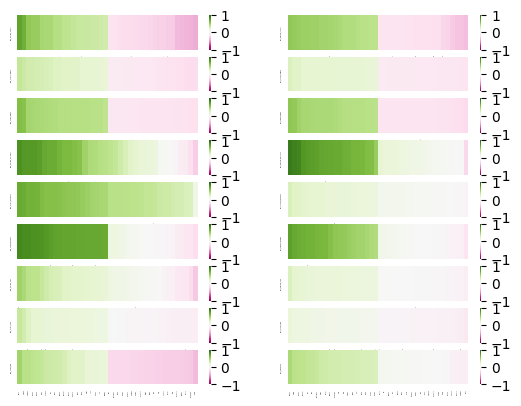

In [429]:
plot_corrs(filtered_sources, n=20)
plt.savefig(fig_dir / f'region_basal_gene_corrs.svg')

In [430]:
import time
import enrichrpy.enrichr as een
import enrichrpy.plotting as epl

diseases = ['brca', 'prad']
dtypes = ['xenium', 'cosmx', 'vishd']
idents = ['region', 'boundary', 'tme']
n = 20
genes = None    
tups = [(ident, dtype) for ident in idents for dtype in dtypes]
pdfs = []
for i, disease in enumerate(diseases):
    for j, dtype in enumerate(dtypes):
        for k, ident in enumerate(idents):
            print(disease, dtype, ident)
            source = filtered_sources[disease][dtype].get(ident)
            if source is not None and source.shape[0]:
                if n * 2 < source.shape[0]:
                    source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                source = source.sort_values('correlation', ascending=False)
                source.index = [c.replace('region_', '').replace('boundary_', '').replace('tme_', '') for c in source.index.to_list()]

                

                genes = source[source['correlation'] > 0].index.to_list()
                if len(genes) >= 10:
                    positive = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
                    positive['direction'] = 'positive'
                    positive['key'] = f'{disease}_{dtype}_{ident}_positive'
                    time.sleep(1)
                else:
                    positive = None
                genes = source[source['correlation'] < 0].index.to_list()
                if len(genes) >= 10:
                    negative = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
                    negative['direction'] = 'negative'
                    negative['key'] = f'{disease}_{dtype}_{ident}_negative'
                    time.sleep(1)
                else:
                    negative = None
                # raise RuntimeError()
                if positive is not None and negative is not None:
                    pdf = pd.concat((positive, negative))
                elif positive is not None:
                    pdf = positive
                elif negative is not None:
                    pdf = negative
                else:
                    pdf = None

                if pdf is not None:
                    pdf['pathway'] = [re.sub(r'^(.*) \(.*$', r'\1', x) for x in pdf['Term name']]
                    pdf['disease'] = disease
                    pdf['dtype'] = dtype
                    pdf['ident'] = ident
                    pdfs.append(pdf)
combined_pdf = pd.concat(pdfs)
combined_pdf['Term name'] = combined_pdf['pathway'].to_list()
combined_pdf
            

brca xenium region
brca xenium boundary
brca xenium tme
brca cosmx region
brca cosmx boundary
brca cosmx tme
brca vishd region
brca vishd boundary
brca vishd tme
prad xenium region
prad xenium boundary
prad xenium tme
prad cosmx region
prad cosmx boundary
prad cosmx tme
prad vishd region
prad vishd boundary
prad vishd tme


,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value,direction,key,pathway,disease,dtype,ident
0,1,regulation of multicellular organismal develop...,0.000354,85.273504,677.710245,"[PTN, GATA3]",0.057691,0,0,positive,brca_xenium_region_positive,regulation of multicellular organismal develop...,brca,xenium,region
1,2,positive regulation of pri-miRNA transcription...,0.000523,69.263889,523.375753,"[JUN, GATA3]",0.057691,0,0,positive,brca_xenium_region_positive,positive regulation of pri-miRNA transcription...,brca,xenium,region
2,3,negative regulation of cell-cell adhesion,0.000761,56.811966,407.959182,"[CDH1, MBP]",0.057691,0,0,positive,brca_xenium_region_positive,negative regulation of cell-cell adhesion,brca,xenium,region
3,4,regulation of cell population proliferation,0.000771,8.441370,60.502667,"[JUN, LAMC2, PTN, GATA3, AREG]",0.057691,0,0,positive,brca_xenium_region_positive,regulation of cell population proliferation,brca,xenium,region
4,5,nervous system development,0.000898,11.025395,77.351391,"[CDH1, PMP22, MBP, PTN]",0.057691,0,0,positive,brca_xenium_region_positive,nervous system development,brca,xenium,region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,576,organelle organization,0.493225,1.505043,1.063750,[DST],0.496650,0,0,positive,prad_vishd_tme_positive,organelle organization,prad,vishd,tme
576,577,regulation of nucleic acid-templated transcrip...,0.501448,1.469208,1.014128,[SNAI2],0.504055,0,0,positive,prad_vishd_tme_positive,regulation of nucleic acid-templated transcrip...,prad,vishd,tme
577,578,regulation of intracellular signal transduction,0.507128,1.445102,0.981214,[VWF],0.508882,0,0,positive,prad_vishd_tme_positive,regulation of intracellular signal transduction,prad,vishd,tme
578,579,regulation of cellular macromolecule biosynthe...,0.531535,1.347033,0.851307,[SNAI2],0.532453,0,0,positive,prad_vishd_tme_positive,regulation of cellular macromolecule biosynthe...,prad,vishd,tme


In [431]:
prefixes = {
    'negative': 'neg.',
    'positive': 'pos.',
    'regulation': 'reg.',
    'proliferation': 'pro.',
    'organization': 'org.'
}
combined_pdf['Term name'] = [' '.join([prefixes.get(z, z) for z in x.split(' ')]) for x in combined_pdf['pathway']]

In [432]:
combined_pdf.to_csv(results_dir / f'pathway_enrichment_correlations.txt', sep='\t')

In [433]:
def enrichment_dotplot(enrichr_results, n=20, hue='Z-score', scheme='viridis', log=True, title=''):
    source = enrichr_results.copy()
    source['Num hits'] = [len(ls) for ls in source['Overlapping genes']]
    source['-log10(FDR)'] = -np.log10(source['Adjusted p-value'])
    source['Pathway'] = source['Term name'].to_list()
    source[f'log({hue})'] = np.log(source[hue])
    
    if n is not None:
        source = source.sort_values('Adjusted p-value').iloc[:n]
        
    
    
    c = alt.Chart(source, title=title).mark_circle().encode(
        x=alt.X('-log10(FDR):Q'),
        y=alt.Y('Pathway', sort={"encoding": "x", "order": "descending"}),
        size=alt.Size('Num hits'),
        color=alt.Color(hue if not log else f'log({hue})', scale=alt.Scale(scheme=scheme, domainMin=0))
    )
    xrule = (
        alt.Chart()
            .mark_rule(strokeDash=[8, 6], color="red", strokeWidth=2)
            .encode(x=alt.datum(-np.log10(.05)))
    )
    return c + xrule

charts = []
for k in sorted(set(combined_pdf['key'])):
    c = enrichment_dotplot(combined_pdf[combined_pdf['key']==k], n=10, hue='Z-score', log=True, title=k)
    charts.append(c)
alt.vconcat(*charts).resolve_scale(color='independent', x='independent', y='independent').configure_axis(grid=True)

alt.VConcatChart(...)

In [434]:
dti_to_cmap = {
    'xenium': 'oranges',
    'xenium5k': 'teals',
    'cosmx': 'browns',
    'cosmx6k': 'purples',
    'vishd': 'cividis',
    'multiplex': 'greens'
}


def generate_subchart(df, key, vmax, cmap='oranges'):
    df['x'] = key
    a = alt.Chart(df).mark_circle(size=250).encode(
        x=alt.X('x'),
        y=alt.Y('feature', sort=df['feature'].to_list()),
        color=alt.Color(key, scale=alt.Scale(scheme=cmap, domain=[0, vmax]))
    )
    
    b = alt.Chart(df).mark_text(baseline="middle", color='white').encode(
        x=alt.X('x'),
        y=alt.Y('feature', sort=df['feature'].to_list()),
        text=alt.Text(key)
    )
    
    return a + b

def generate_chart_row(source, disease, dti):
    max_cases = len(dti_to_cases[disease][dti])
    max_sids = len(dti_to_sids[disease][dti])
    print(max_cases, max_sids)
    
    cs = []
    for k in ['sid_count', 'case_count']:
        cs.append(generate_subchart(source,
                                    k,
                                    vmax=max_cases if k == 'case_count' else max_sids,
                                    cmap=dti_to_cmap[dti]))
    
    f = source
    f['x'] = 'correlation'
    a = alt.Chart(f, title=f'{disease}_{dti}').mark_rect().encode(
        x=alt.X('x'),
        y=alt.Y('feature', sort=f['feature'].to_list()),
        color=alt.Color('correlation', scale=alt.Scale(scheme="pinkyellowgreen", domain=[-1, 1], reverse=False))
    )
    cs.append(a)
    
    return alt.hconcat(*cs).resolve_scale(color='independent')

In [435]:
filtered_to_source = {}
for disease, d1 in to_source.items():
    filtered_to_source[disease] = {}
    for dti, d2 in d1.items():
        filtered_to_source[disease][dti] = {}
        for direction, source in d2.items():
            f = source.copy()
            genes = [x.replace('region_', '') for x in f['feature']]
            keep = []
            for gene in genes:
                if gene in gene_to_distribution and gene_to_distribution[gene][disease] in ['all', 'luminal', 'luminal/basal']:
                    keep.append(gene)
            f = f[[g in keep for g in genes]]
            filtered_to_source[disease][dti][direction] = f
                    





In [436]:
filtered_to_source['brca']['xenium']['positive']

,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
45012,brca,xenium,region,region_PPP1R1B,12,4,0.373405,0.373405,positive
45030,brca,xenium,region,region_PTN,13,3,0.454701,0.454701,positive
43882,brca,xenium,region,region_ANPEP,12,3,0.313833,0.313833,positive
45324,brca,xenium,region,region_VWA5A,11,3,0.347634,0.347634,positive
44886,brca,xenium,region,region_MS4A6A,11,3,0.284958,0.284958,positive
44784,brca,xenium,region,region_LAMC2,10,3,0.410025,0.410025,positive
44500,brca,xenium,region,region_EHF,10,3,0.258534,0.258534,positive
44264,brca,xenium,region,region_CD14,9,3,0.233983,0.233983,positive
45006,brca,xenium,region,region_PMP22,8,3,0.332969,0.332969,positive
44208,brca,xenium,region,region_C1orf162,4,3,0.141977,0.141977,positive


In [438]:
filtered_to_source['brca']['xenium']['negative']

,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
44616,brca,xenium,region,region_GPRC5A,13,3,-0.377744,0.377744,negative
44244,brca,xenium,region,region_CCDC78,11,3,-0.176390,0.176390,negative
45058,brca,xenium,region,region_RIDA,10,3,-0.153141,0.153141,negative
44576,brca,xenium,region,region_GATA2,8,3,-0.150677,0.150677,negative
45212,brca,xenium,region,region_TBX3,8,3,-0.088409,0.088409,negative
...,...,...,...,...,...,...,...,...,...
44486,brca,xenium,region,region_EFNB2,0,0,0.028375,0.028375,negative
44916,brca,xenium,region,region_NKX3-1,0,0,-0.021142,0.021142,negative
44910,brca,xenium,region,region_NDRG1,0,0,0.010739,0.010739,negative
44192,brca,xenium,region,region_BRCA1,0,0,0.003138,0.003138,negative


In [439]:
import altair as alt
n = 20
s = None
charts = []
gene_dict = {}
for disease, d1 in filtered_to_source.items():
    if disease not in gene_dict:
        gene_dict[disease] = {}
    for dti, d2 in d1.items():
        if dti not in gene_dict[disease]:
            gene_dict[disease][dti] = {}
        for direction, source in d2.items():
            print(disease, dti, source.shape)
            
            if source.shape[0]:
                s = source.iloc[:n].copy()
                s['feature'] = [x.replace('region_', '') for x in s['feature']]
                charts.append(generate_chart_row(s, disease, dti))
                gene_dict[disease][dti][direction] = s['feature'].to_list()
                
            else:
                print(f'{disease} {dti} is missing')
                

alt.vconcat(*charts).resolve_scale(color='independent', x='independent', y='independent')

brca cosmx (38, 9)
2 5
brca cosmx (145, 9)
2 5
brca vishd (91, 9)
1 2
brca vishd (547, 9)
1 2
brca xenium (49, 9)
4 15
brca xenium (115, 9)
4 15
brca cosmx6k (0, 0)
brca cosmx6k is missing
brca cosmx6k (0, 0)
brca cosmx6k is missing
brca multiplex (0, 9)
brca multiplex is missing
brca multiplex (0, 9)
brca multiplex is missing
brca xenium5k (0, 0)
brca xenium5k is missing
brca xenium5k (0, 0)
brca xenium5k is missing
prad cosmx (0, 0)
prad cosmx is missing
prad cosmx (0, 0)
prad cosmx is missing
prad vishd (129, 9)
1 2
prad vishd (504, 9)
1 2
prad xenium (80, 9)
25 49
prad xenium (72, 9)
25 49
prad cosmx6k (47, 9)
1 2
prad cosmx6k (441, 9)
1 2
prad multiplex (0, 9)
prad multiplex is missing
prad multiplex (0, 9)
prad multiplex is missing
prad xenium5k (112, 9)
3 5
prad xenium5k (254, 9)
3 5


alt.VConcatChart(...)

In [440]:
source = None
to_gene_corr_sources = {}
for disease, d1 in filtered_to_source.items():
    if disease not in to_gene_corr_sources:
        to_gene_corr_sources[disease] = {}
    for dti, d2 in d1.items():
        if dti not in to_gene_corr_sources[disease]:
            to_gene_corr_sources[disease][dti] = {}
        for direction, source in d2.items():
            if source.shape[0]:
                s = source.iloc[:n].copy()
                feats = [x.replace('region_', '') for x in s['feature']]
        
                source = get_corr_source_table(feats)
        
                to_gene_corr_sources[disease][dti][direction] = source
        
                source.to_csv(results_dir / f'dti_corr_by_sid_{disease}_{direction}.txt', sep='\t')

In [441]:
to_gene_corr_sources['brca']['xenium']['positive']

,HT206B1-U1,HT206B1-U8,HT206B1-U9,HT206B1-U16,HT206B1-U17,HT206B1-U24,HT2681-Th1H3L1U2,HT268B1-Th1H3L1U1,HT591B1-S1H1Fp1Us1_1,HT704B1-U1,...,S22-53426-A1U3,HT832Z1U1,HT913Z1-U1,HT913Z1-U11,HT913Z1-U21,S18-8122-B28U1,HT891Z1-U57,HT891Z1-U60,HT891Z1-U2,HT891Z1-U33
feature,,,,,,,,,,,,,,,,,,,,,
PPP1R1B,0.278460,0.284365,0.546564,0.176323,0.199234,0.453791,0.170817,0.244944,0.558736,0.477497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTN,0.706250,0.482581,0.592129,0.563158,0.530275,0.477101,0.036185,0.108496,0.452004,0.560968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANPEP,0.254028,0.286362,0.441795,0.174291,0.255124,0.290529,-0.097206,-0.060656,0.406045,0.406228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VWA5A,0.681920,0.776841,0.750945,0.429570,0.559767,0.658715,0.216789,-0.188295,0.113599,0.231137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS4A6A,0.328358,0.288541,0.380305,0.328915,0.135190,0.195423,-0.030727,0.037811,0.291752,0.458912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAMC2,0.669676,NaN,0.438598,NaN,0.607417,NaN,0.264270,NaN,NaN,0.528719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EHF,0.296658,0.188655,0.417948,0.198692,0.298212,0.430995,0.260107,0.050628,0.146460,0.098558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD14,0.152126,0.047262,0.368016,-0.018993,0.174681,0.280798,-0.058310,0.062079,0.262552,0.426494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PMP22,0.626270,0.750784,0.642594,0.688388,0.695826,0.661991,-0.026500,0.037179,0.294408,0.267808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


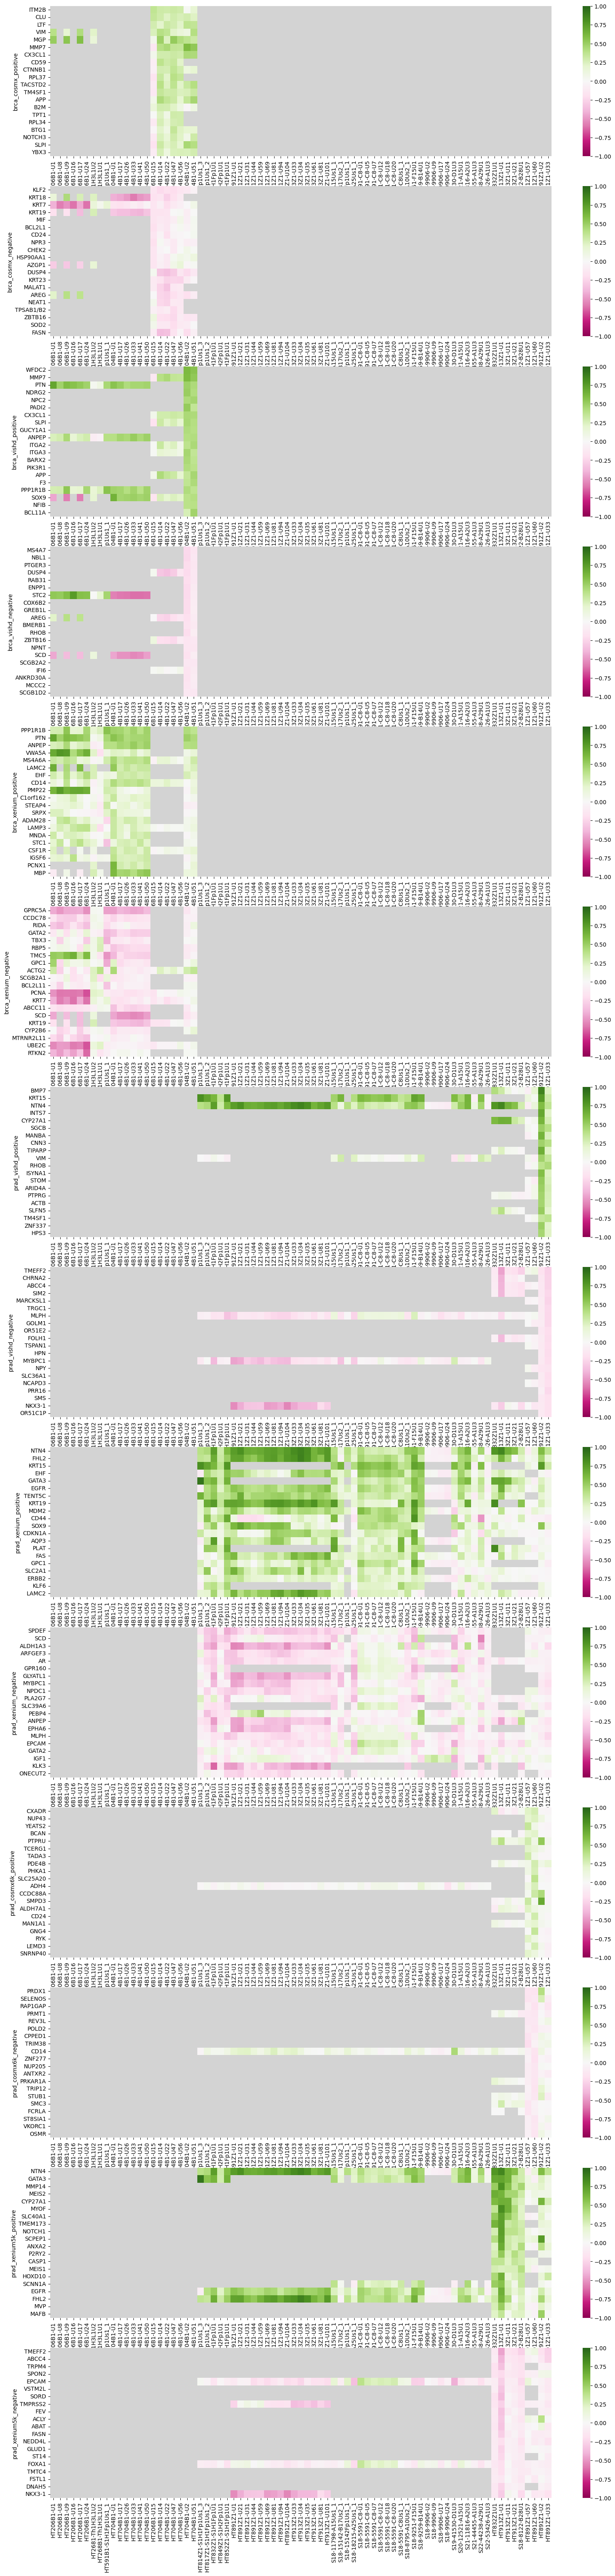

In [442]:
fig, axs = plt.subplots(nrows=14, figsize=(20, 80))
i = 0
for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, source in d2.items():
            ax = axs[i]
            # if direction == 'positive':
            X = source.values.copy()
            # vmin = X[~pd.isnull(X)].min()
            # vmax = X[~pd.isnull(X)].max()
            cmap = 'PiYG'
            # else:
                # X = source.values.copy()
                # vmin = X[~pd.isnull(X)].min()
                # vmax = X[~pd.isnull(X)].max()
                # cmap = 'PiYG'
            divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
            
            sns.heatmap(source, cmap=cmap, norm=divnorm, ax=ax)
            ax.set_ylabel(f'{disease}_{dti}_{direction}')
            ax.set_facecolor('lightgray')

            # for x in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            #     x.set_fontsize(4)
                
            i += 1
plt.savefig(fig_dir / f'dti_correlation_heatmaps.svg')

In [443]:
pdfs = []
for disease, d1 in gene_dict.items():
    for dti, d2 in d1.items():
        for direction, genes in d2.items():
            pdf = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
            pdf['direction'] = 'negative'
            pdf['key'] = f'{disease}_{dti}_{direction}'
            time.sleep(1)

            pdf['pathway'] = [re.sub(r'^(.*) \(.*$', r'\1', x) for x in pdf['Term name']]
            pdf['disease'] = disease
            pdf['dtype'] = dtype
            pdf['ident'] = ident
            pdfs.append(pdf)

combined_pdf = pd.concat(pdfs)
combined_pdf['Term name'] = combined_pdf['pathway'].to_list()
combined_pdf['Term name'] = [' '.join([prefixes.get(z, z) for z in x.split(' ')]) for x in combined_pdf['pathway']]
combined_pdf.to_csv(results_dir / f'pathway_enrichment_dtype_specific_correlations.txt', sep='\t')
combined_pdf

,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value,direction,key,pathway,disease,dtype,ident
0,1,amyloid fibril formation,4.169249e-07,84.411017,1240.028213,"[APP, B2M, ITM2B, LTF]",0.000255,0,0,negative,brca_cosmx_positive,amyloid fibril formation,brca,vishd,tme
1,2,microglial cell activation,1.300921e-06,185.396285,2512.571623,"[APP, CLU, CX3CL1]",0.000398,0,0,negative,brca_cosmx_positive,microglial cell activation,brca,vishd,tme
2,3,pos. reg. of DNA-binding transcription factor ...,3.603654e-06,27.301521,342.185316,"[APP, CTNNB1, CLU, CX3CL1, LTF]",0.000735,0,0,negative,brca_cosmx_positive,positive regulation of DNA-binding transcripti...,brca,vishd,tme
3,4,macrophage activation,5.978041e-06,106.668449,1282.945984,"[APP, CLU, CX3CL1]",0.000773,0,0,negative,brca_cosmx_positive,macrophage activation,brca,vishd,tme
4,5,reg. of tumor necrosis factor production,6.314593e-06,41.375000,495.368277,"[APP, CLU, CX3CL1, LTF]",0.000773,0,0,negative,brca_cosmx_positive,regulation of tumor necrosis factor production,brca,vishd,tme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,347,neg. reg. of cellular macromolecule biosynthet...,4.258621e-01,1.873337,1.599155,[NKX3-1],0.430771,0,0,negative,prad_xenium5k_negative,negative regulation of cellular macromolecule ...,prad,vishd,tme
347,348,neg. reg. of cellular process,4.369794e-01,1.808570,1.497260,[NKX3-1],0.440746,0,0,negative,prad_xenium5k_negative,negative regulation of cellular process,prad,vishd,tme
348,349,neg. reg. of transcription by RNA polymerase II,5.015766e-01,1.487015,1.026039,[NEDD4L],0.504451,0,0,negative,prad_xenium5k_negative,negative regulation of transcription by RNA po...,prad,vishd,tme
349,350,cellular protein modification process,6.510094e-01,0.974301,0.418200,[FSTL1],0.652869,0,0,negative,prad_xenium5k_negative,cellular protein modification process,prad,vishd,tme


In [444]:
charts = []
for k in sorted(set(combined_pdf['key'])):
    c = enrichment_dotplot(combined_pdf[combined_pdf['key']==k], n=10, hue='Z-score', log=True, title=k)
    charts.append(c)
alt.vconcat(*charts).resolve_scale(color='independent', x='independent', y='independent').configure_axis(grid=True)

alt.VConcatChart(...)

In [445]:
to_consensus_filtered = {}
source = None
for disease in ['brca', 'prad']:
    to_consensus_filtered[disease] = {}
    for direction in ['positive', 'negative']:
        m = (grouped['disease']==disease) & (grouped['direction']==direction)
        source = grouped[m].sort_values(['count_neg', 'rank_pct'])
        # raise RuntimeError()
        keep = []
        for gene in source['feature']:
            if gene in gene_to_distribution and gene_to_distribution[gene][disease] in ['all', 'luminal', 'luminal/basal']:
                keep.append(gene)
        source = source[[g in keep for g in source['feature']]]
        
        fp = results_dir / f'disease_specific_consensus_features_{disease}_{direction}.txt'
        source.to_csv(fp, sep='\t', index=False)

        to_consensus_filtered[disease][direction] = source



In [446]:
def generate_consensus_chart(disease, direction, n=20):
    source = to_consensus_filtered[disease][direction].iloc[:20]
    
    a = alt.Chart(source, title=f'{disease}_{direction}').mark_rect().encode(
        y=alt.Y('feature', sort=source['feature'].to_list()),
        color=alt.Color('rank_pct', scale=alt.Scale(scheme="viridis", domain=[0, 1.], reverse=True))
    )

    cols = ['xenium_rank', 'xenium5k_rank', 'cosmx_rank', 'cosmx6k_rank', 'vishd_rank']
    melted = source.melt(id_vars=['disease', 'feature'], value_vars=cols)

    dti_to_color = {
        'xenium': 'darkorange',
        'xenium5k': 'teal',
        'cosmx': 'brown',
        'cosmx6k': 'purple',
        'vishd': 'gold'
    }
    cs = []
    for x in cols:
        f = melted[melted['variable']==x]
    
        b = alt.Chart(f, title=x).mark_rect(color=dti_to_color[x.split('_')[0]], strokeWidth=1, stroke='lightgray').encode(
            y=alt.Y('feature', sort=source['feature'].to_list()),
            # color=alt.Color('variable', scale=alt.Scale()),
        )
        
        c = alt.Chart(f).mark_text(baseline="middle", color='white').encode(
            y=alt.Y('feature', sort=source['feature'].to_list()),
            text=alt.Text('value'),
        )
    
        cs.append(b + c)
    aa = alt.hconcat(*cs).resolve_scale(color='independent', x='independent', y='independent')

    return alt.hconcat(a, aa).resolve_scale(color='independent', x='independent', y='independent')


In [447]:
disease, direction = 'brca', 'positive'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [448]:
def gse_consensus(disease, direction):
    pdf = een.get_pathway_enrichment(
        to_consensus_filtered[disease][direction].iloc[:20]['feature'],
        gene_set_library='GO_Biological_Process_2021')
    pdf['Term name'] = [re.sub(r'^(.*) \(.*$', r'\1', x) for x in pdf['Term name']]
    pdf['Term name'] = [' '.join([prefixes.get(z, z) for z in x.split(' ')]) for x in pdf['Term name']]
    pdf.to_csv(results_dir / f'pathway_enrichment_consensus_correlations_{disease}_{direction}.txt', sep='\t')
    return enrichment_dotplot(pdf, n=20, hue='Z-score', log=True, title=f'{disease}_{direction}')
gse_consensus(disease, direction)

alt.LayerChart(...)

In [449]:
disease, direction = 'brca', 'negative'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [450]:
gse_consensus(disease, direction)

alt.LayerChart(...)

In [451]:
disease, direction = 'prad', 'positive'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [452]:
gse_consensus(disease, direction)

alt.LayerChart(...)

In [453]:
disease, direction = 'prad', 'negative'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [454]:
gse_consensus(disease, direction)

alt.LayerChart(...)

In [455]:
source = None
to_gene_consensus_corr_sources = {}
for disease, d1 in to_consensus_filtered.items():
    to_gene_consensus_corr_sources[disease] = {}
    for direction, f in d1.items():
        feats = f['feature'].to_list()[:25]

        combined = []
        for dti in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']:
            dtype = dti.replace('5k', '').replace('6k', '')
            f = raw_corrs[f'{disease}_{dtype}_region'].copy()
            f = f[f['dtype_ident']==dti]
            f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
            combined.append(f)
        combined = pd.concat(combined)

        
        data = []
        for feat in feats:
            for sid in sid_order:
                if f'{feat}_{sid}' in combined.index:
                    val = combined.loc[f'{feat}_{sid}', 'correlation']
                else:
                    val = np.nan
                data.append([feat, sid, val])

        source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
        source = source.pivot(columns='sid', index='feature')
        source.columns = [x for _, x in source.columns]
        source = source[sid_order]
        source = source.loc[feats]

        to_gene_consensus_corr_sources[disease][direction] = source

        source.to_csv(results_dir / f'consensus_corr_by_sid_{disease}_{direction}.txt', sep='\t')

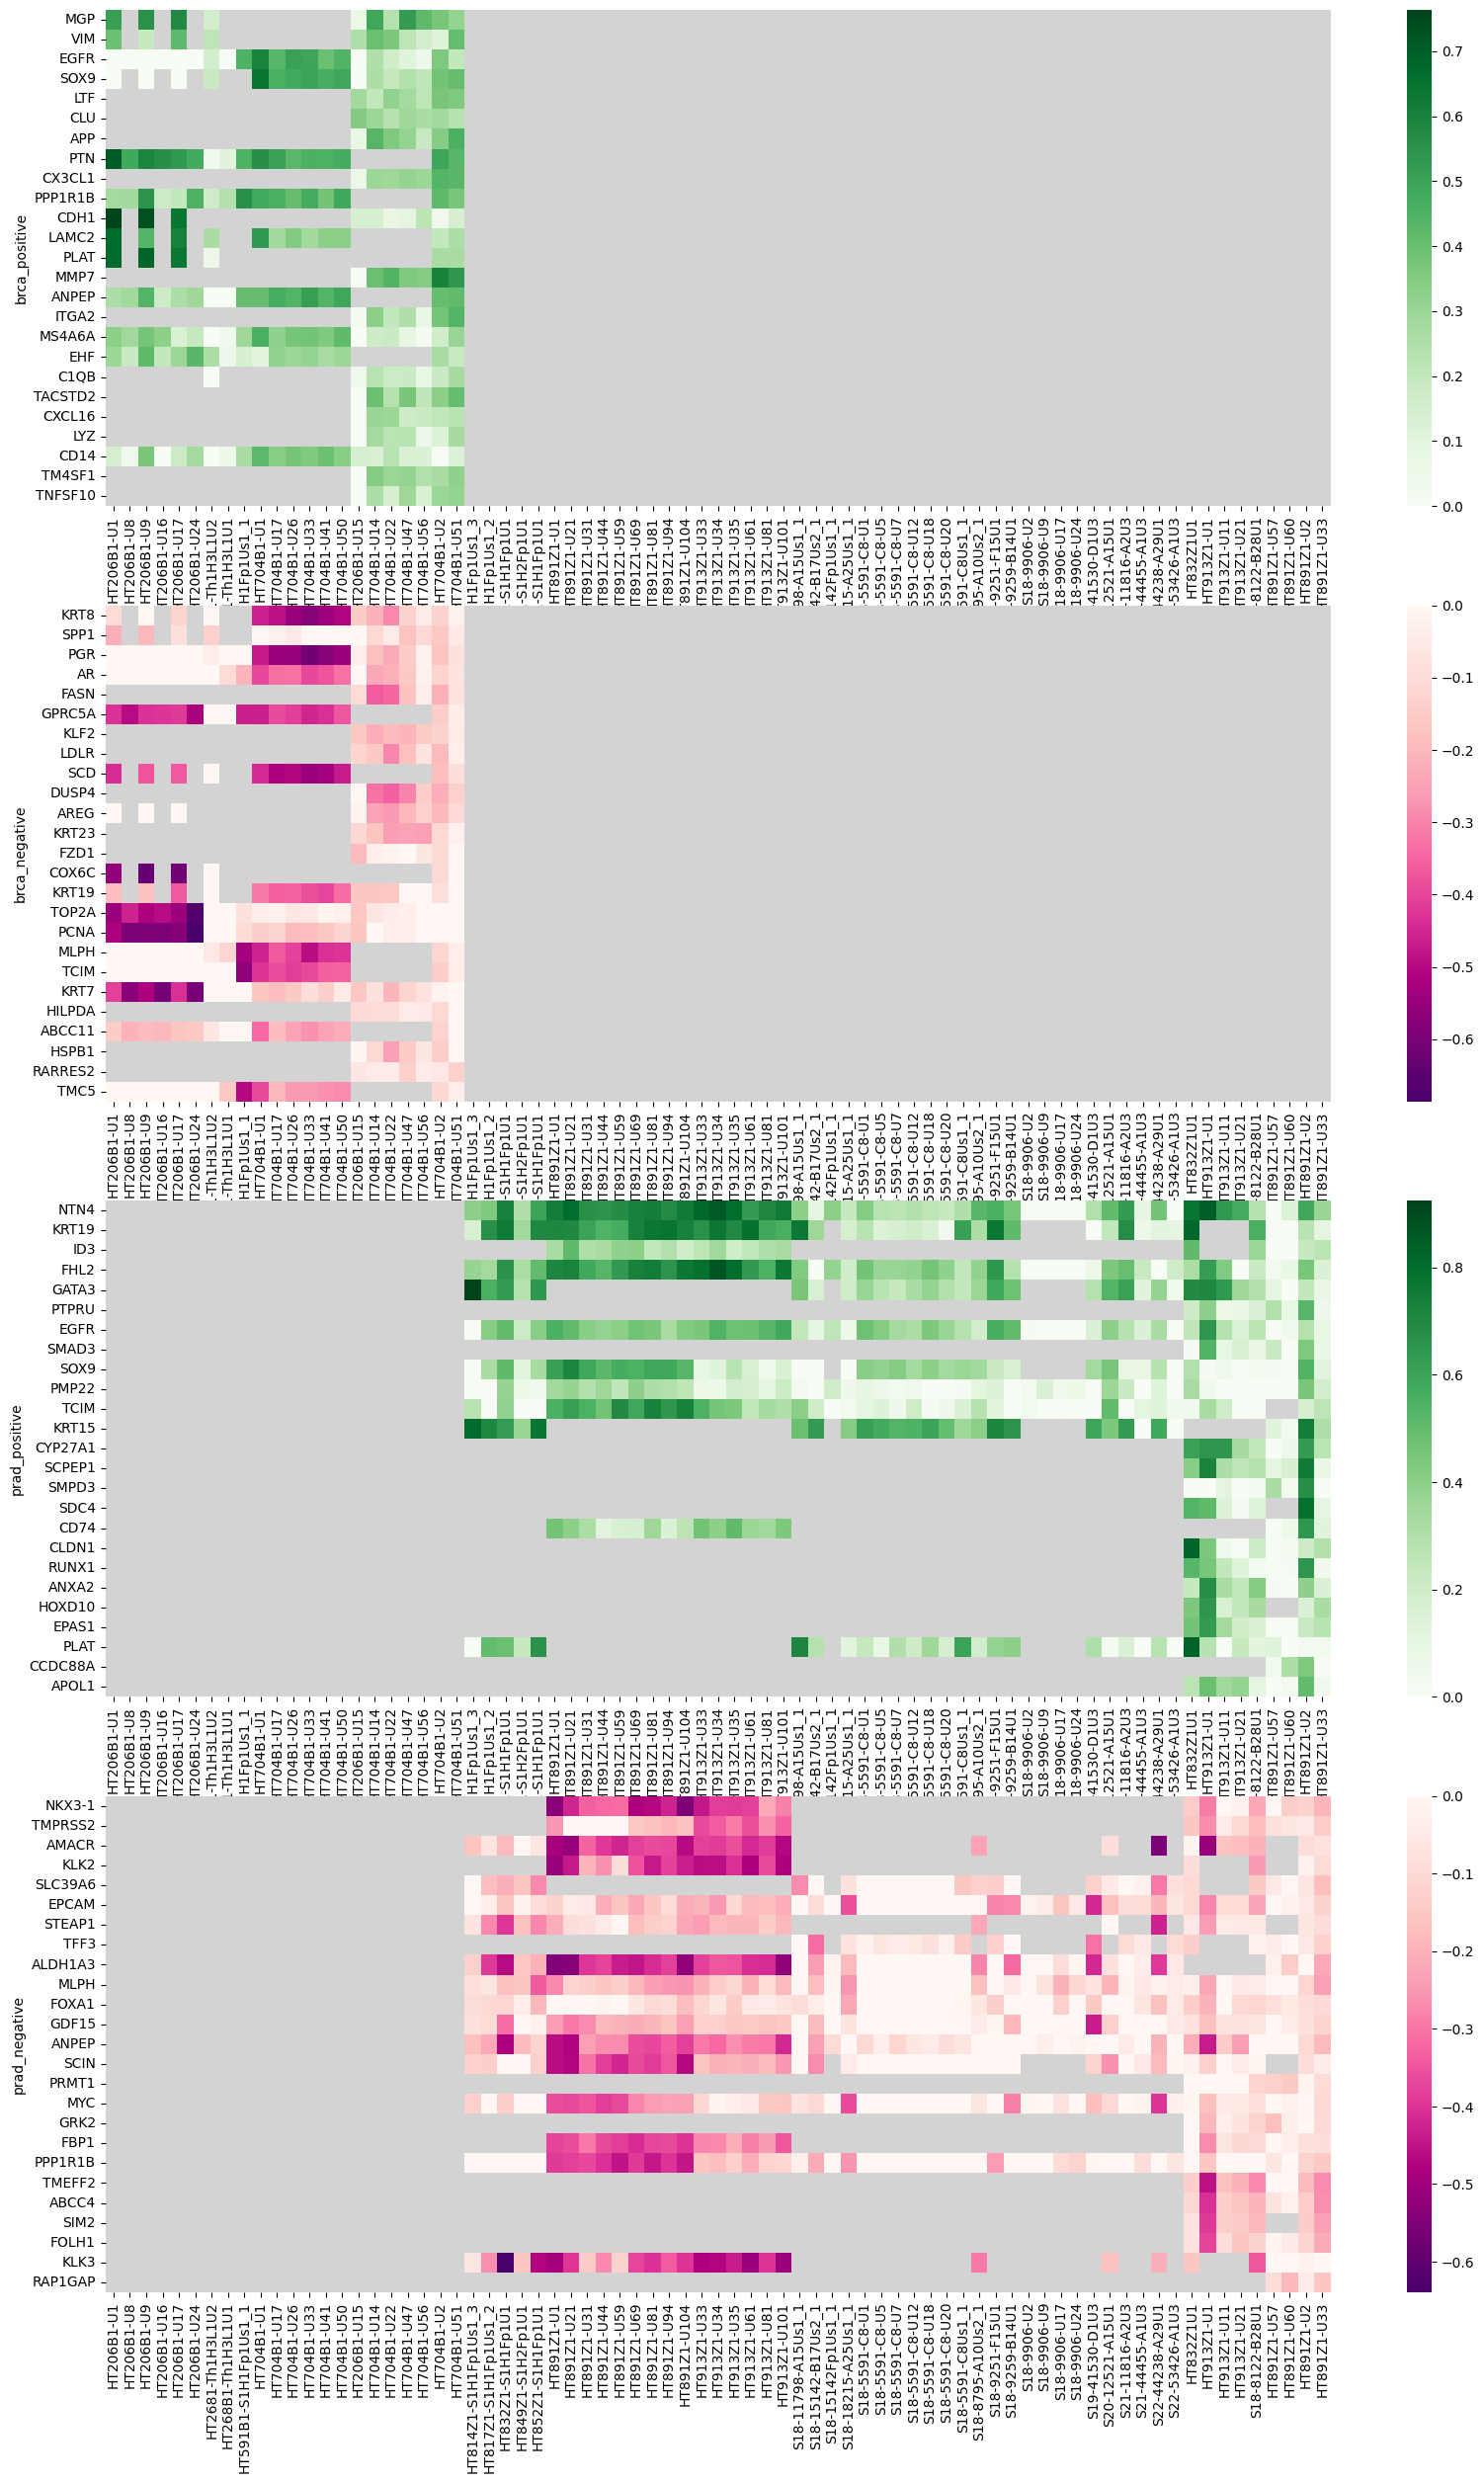

In [457]:
fig, axs = plt.subplots(nrows=4, figsize=(20, 30))
i = 0
for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, source in d1.items():
        ax = axs[i]
        if direction == 'positive':
            X = source.values.copy()
            vmin = 0
            vmax = X[~pd.isnull(X)].max()
            cmap = 'Greens'
        else:
            X = source.values.copy()
            vmin = X[~pd.isnull(X)].min()
            vmax = 0
            cmap = 'RdPu_r'
        sns.heatmap(source, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
        ax.set_ylabel(f'{disease}_{direction}')
        ax.set_facecolor('lightgray')
        i += 1
plt.savefig(fig_dir / f'consensus_correlation_heatmaps.svg')

In [458]:
def get_combined_df(to_consensus_filtered, direction):
    df1 = to_consensus_filtered['brca'][direction].copy()
    df1 = df1.set_index('feature')
    df1.columns = [f'brca_{x}' for x in df1.columns]
    
    df2 = to_consensus_filtered['prad'][direction].copy()
    df2 = df2.set_index('feature')
    df2.columns = [f'prad_{x}' for x in df2.columns]
    
    dat = pd.merge(df1, df2, how='outer', left_index=True, right_index=True)
    dat['combined_count'] = dat['brca_count'] + dat['prad_count']
    dat['count_delta'] = dat['brca_count'] - dat['prad_count']
    
    return dat

In [459]:
direction_to_source = {}
for direction in ['positive', 'negative']:
    df = get_combined_df(to_consensus_filtered, direction)
    df['feature'] = df.index.to_list()
    
    cols = ['feature', 'combined_count']
    cols += [f'{disease}_{x}_rank' for disease in ['brca', 'prad'] for x in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']]
    cols += ['brca_rank_pct', 'prad_rank_pct']
    source = df[cols]
    source['rank_pct'] = (source['brca_rank_pct'] + source['prad_rank_pct']) / 2
    source['combined_count_neg'] = -source['combined_count']
    source = source.sort_values(['combined_count_neg', 'rank_pct'], ascending=True)
    direction_to_source[direction] = source

/tmp/ipykernel_2446480/3113182435.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['rank_pct'] = (source['brca_rank_pct'] + source['prad_rank_pct']) / 2
/tmp/ipykernel_2446480/3113182435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['combined_count_neg'] = -source['combined_count']
/tmp/ipykernel_2446480/3113182435.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [460]:
def generate_combined_consensus_chart(source):
    
    a = alt.Chart(source).mark_rect().encode(
        y=alt.Y('feature', sort=source['feature'].to_list()),
        color=alt.Color('rank_pct', scale=alt.Scale(scheme="viridis", domain=[0, 1.], reverse=True))
    )

    cols = [c for c in source.columns if re.findall(r'_rank$', c)]
    print(cols)
    melted = source.melt(id_vars=['feature'], value_vars=cols)

    dti_to_color = {
        'xenium': 'darkorange',
        'xenium5k': 'teal',
        'cosmx': 'brown',
        'cosmx6k': 'purple',
        'vishd': 'gold'
    }
    cs = []
    for x in cols:
        f = melted[melted['variable']==x]
    
        b = alt.Chart(f, title=x).mark_rect(color=dti_to_color[x.split('_')[1]], strokeWidth=1, stroke='lightgray').encode(
            y=alt.Y('feature', sort=source['feature'].to_list()),
            # color=alt.Color('variable', scale=alt.Scale()),
        )
        
        c = alt.Chart(f).mark_text(baseline="middle", color='white').encode(
            y=alt.Y('feature', sort=source['feature'].to_list()),
            text=alt.Text('value'),
        )
    
        cs.append(b + c)
    aa = alt.hconcat(*cs).resolve_scale(color='independent', x='independent', y='independent')

    return alt.hconcat(a, aa).resolve_scale(color='independent', x='independent', y='independent')


In [461]:
generate_combined_consensus_chart(direction_to_source['positive'].iloc[:20])

['brca_xenium_rank', 'brca_xenium5k_rank', 'brca_cosmx_rank', 'brca_cosmx6k_rank', 'brca_vishd_rank', 'prad_xenium_rank', 'prad_xenium5k_rank', 'prad_cosmx_rank', 'prad_cosmx6k_rank', 'prad_vishd_rank']


alt.HConcatChart(...)

In [462]:
def gse_combined_consensus(direction):
    pdf = een.get_pathway_enrichment(
        direction_to_source[direction].iloc[:20]['feature'],
        gene_set_library='GO_Biological_Process_2021')
    pdf['Term name'] = [re.sub(r'^(.*) \(.*$', r'\1', x) for x in pdf['Term name']]
    pdf['Term name'] = [' '.join([prefixes.get(z, z) for z in x.split(' ')]) for x in pdf['Term name']]
    pdf.to_csv(results_dir / f'pathway_enrichment_consensus_correlations_{disease}_{direction}.txt', sep='\t')
    return enrichment_dotplot(pdf, n=20, hue='Z-score', log=True, title=f'{disease}_{direction}')
gse_combined_consensus('positive')

alt.LayerChart(...)

In [463]:
generate_combined_consensus_chart(direction_to_source['negative'].iloc[:20])

['brca_xenium_rank', 'brca_xenium5k_rank', 'brca_cosmx_rank', 'brca_cosmx6k_rank', 'brca_vishd_rank', 'prad_xenium_rank', 'prad_xenium5k_rank', 'prad_cosmx_rank', 'prad_cosmx6k_rank', 'prad_vishd_rank']


alt.HConcatChart(...)

In [464]:
gse_combined_consensus('negative')

alt.LayerChart(...)

In [465]:
source = None
combined = None
to_combined_corr_sources = {}
for direction, f in direction_to_source.items():
    feats = f['feature'].to_list()[:25]

    combined = []
    for dti in ['xenium', 'xenium5k', 'cosmx', 'cosmx6k', 'vishd']:
        dtype = dti.replace('5k', '').replace('6k', '')
        f = pd.concat((raw_corrs[f'brca_{dtype}_region'], raw_corrs[f'prad_{dtype}_region']))
        f = f[f['dtype_ident']==dti]
        f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
        combined.append(f)
    combined = pd.concat(combined)

    
    data = []
    for feat in feats:
        for sid in sid_order:
            if f'{feat}_{sid}' in combined.index:
                val = combined.loc[f'{feat}_{sid}', 'correlation']
            else:
                val = np.nan
            data.append([feat, sid, val])

    source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
    source = source.pivot(columns='sid', index='feature')
    source.columns = [x for _, x in source.columns]
    source = source[sid_order]
    source = source.loc[feats]

    to_combined_corr_sources[direction] = source

    source.to_csv(results_dir / f'combined_consensus_corr_by_sid_{direction}.txt', sep='\t')

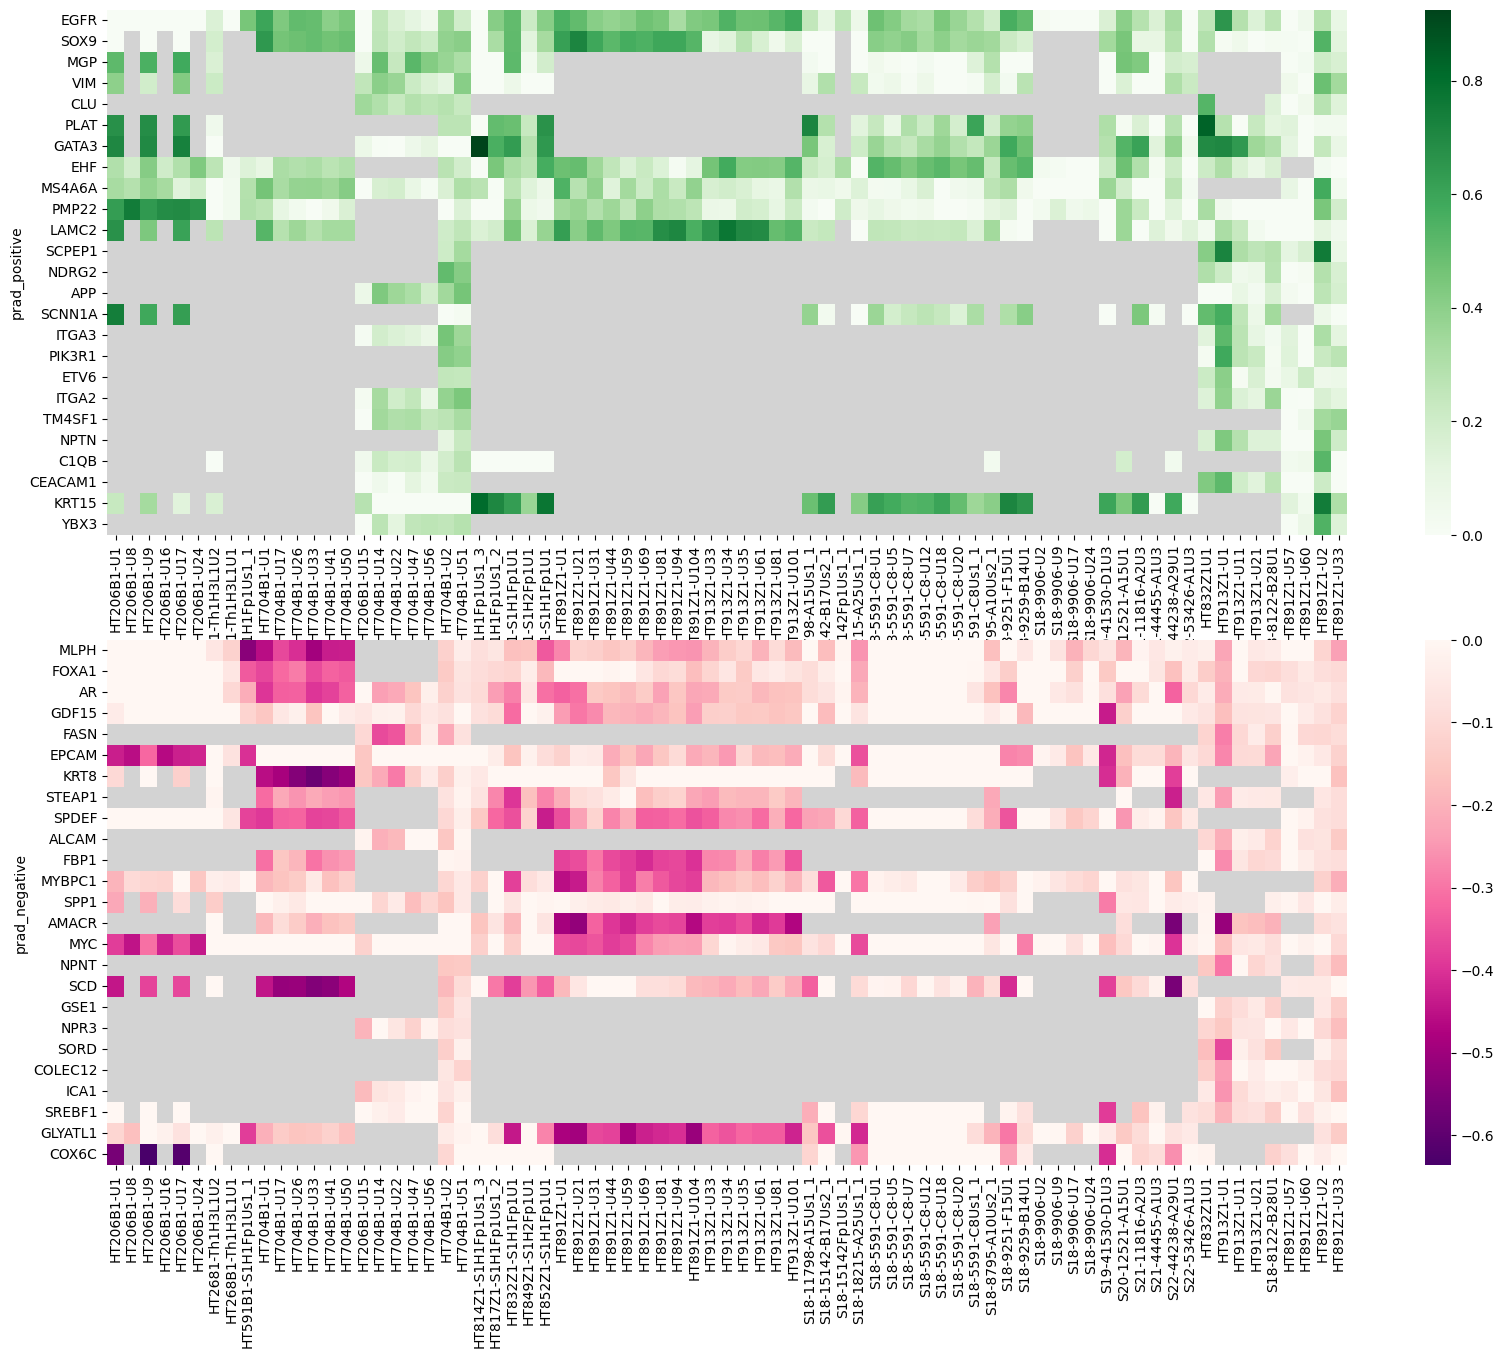

In [466]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 15))
i = 0
for direction, source in to_combined_corr_sources.items():
    ax = axs[i]
    if direction == 'positive':
        X = source.values.copy()
        X[pd.isnull(X)] = 0
        vmin = 0
        vmax = X.max()
        cmap = 'Greens'
    else:
        X = source.values.copy()
        X[pd.isnull(X)] = 0
        vmin = X.min()
        vmax = 0
        cmap = 'RdPu_r'
    sns.heatmap(source, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_ylabel(f'{disease}_{direction}')
    ax.set_facecolor('lightgray')
    i += 1
plt.savefig(fig_dir / f'combined_consensus_correlation_heatmaps.svg')

In [467]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/analysis/region_characterization/figures')

In [377]:
def get_consensus_twinned(direction):

    df1 = to_consensus_filtered['brca'][direction]
    df2 = to_consensus_filtered['prad'][direction]
    shared = sorted(set(df1['feature']).intersection(set(df2['feature'])))
    
    df1 = df1.set_index('feature')
    df2 = df2.set_index('feature')
    
    df1 = df1.loc[shared]
    df2 = df2.loc[shared]
    
    new = pd.DataFrame.from_dict({
        'feature': shared,
        'rank_pct_brca': df1['rank_pct'],
        'rank_pct_prad': df2['rank_pct'],
    })
    
    new = new[((new['rank_pct_brca'] < 1.) & (new['rank_pct_prad'] < 1.))]

    return new

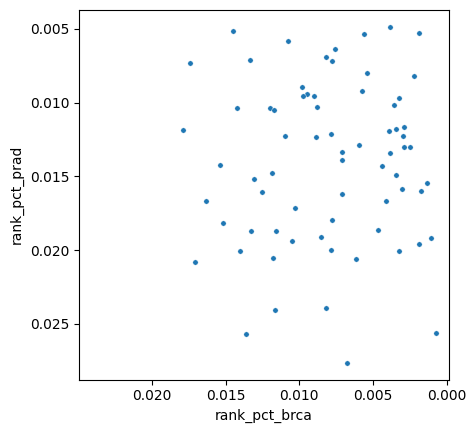

In [378]:
new = get_consensus_twinned('positive')

sns.scatterplot(data=new, x='rank_pct_brca', y='rank_pct_prad', s=15)
plt.axis('square')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig(fig_dir / 'consensus_scatterplot_all_positive.svg')

In [116]:
f = new.copy()
f['score'] = (1 - f['rank_pct_brca']) * (1 - f['rank_pct_prad'])
f = f[f['rank_pct_brca'] < .05]
f = f[f['rank_pct_prad'] < .05]
for g in f.sort_values('score', ascending=False).index.to_list():
    print(g)

DST
TNC
COL17A1
LTBP2
TP63
FGL2
KRT5
CAVIN1
ITGB4
GAS6
EGFR
ITGB6
ITGA2
CAV1
GLIPR1
ITGA3
PLAT
VIM
CLCA2
MS4A6A
MGP
EHF
CX3CL1
NOTCH1
SPI1
CFTR


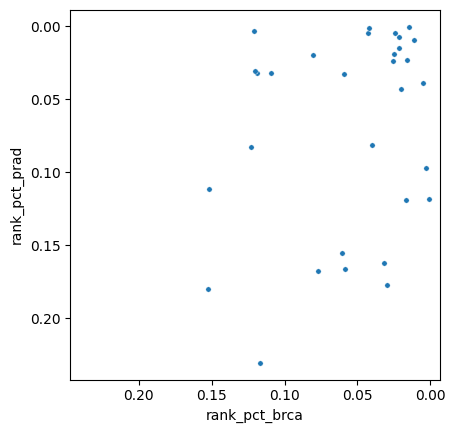

In [117]:
new = get_consensus_twinned('negative')

sns.scatterplot(data=new, x='rank_pct_brca', y='rank_pct_prad', s=15)
plt.axis('square')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig(fig_dir / 'consensus_scatterplot_all_negative.svg')

In [118]:
f = new.copy()
f['score'] = (1 - f['rank_pct_brca']) * (1 - f['rank_pct_prad'])
f = f[f['rank_pct_brca'] < .05]
f = f[f['rank_pct_prad'] < .05]
for g in f.sort_values('score', ascending=False).index.to_list():
    print(g)

MYBPC1
FASN
FBP1
STEAP1
ALCAM
CCDC78
GLYATL1
AR
SCD
EPHA6
LDLR
XBP1


In [119]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [120]:
f = None
v = None
disease_to_dtype_to_df = {}
for k, v in corr_dfs.items():
    disease, dtype, rtype = k.split('_')

    if rtype == 'region':
        exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
        idxs = [i for i in v.index.to_list() if not len([x for x in exclude if x in i])]
        f = v.loc[idxs]
        f = f[~pd.isnull(f['correlation'])]
        f.index = [x.replace('region_', '') for x in f.index.to_list()]

        if disease not in disease_to_dtype_to_df:
            disease_to_dtype_to_df[disease] = {}
        disease_to_dtype_to_df[disease][dtype] = f


In [121]:
disease_to_dtype_to_df['prad']['xenium']

,correlation,pvalue
KLK2,-0.361756,1.115494e-03
TRPM8,-0.317642,1.859622e-01
KLK3,-0.304682,5.622084e-02
NKX3-1,-0.270167,6.904089e-03
AMACR,-0.263292,2.586785e-02
...,...,...
CPA6,0.690171,2.529907e-02
GJA1,0.698063,2.230048e-09
ITGB4,0.704617,2.155508e-02
LAMB3,0.713547,7.823572e-06


In [122]:
dtype_to_df = {}
for dtype in ['xenium', 'vishd']:
    df1 = disease_to_dtype_to_df['brca'][dtype]
    df2 = disease_to_dtype_to_df['prad'][dtype]
    shared = sorted(set(df1.index.to_list()).intersection(set(df2.index.to_list())))
    
    df1 = df1.loc[shared]
    df2 = df2.loc[shared]
    
    new = pd.DataFrame.from_dict({
        'feature': shared,
        'corr_brca': df1['correlation'],
        'corr_prad': df2['correlation'],
    })
    
    dtype_to_df[dtype] = new


In [123]:
dtype_to_df['xenium']

,feature,corr_brca,corr_prad
ABCC11,ABCC11,-0.152185,0.006416
ACAN,ACAN,-0.084902,-0.028095
ACE2,ACE2,0.095140,0.128072
ACKR1,ACKR1,0.033729,0.026844
ACTA2,ACTA2,0.671197,0.040911
...,...,...,...
VIM,VIM,0.436127,0.098713
VPREB1,VPREB1,-0.026871,0.025934
VSIG4,VSIG4,0.157640,0.130123
VWA5A,VWA5A,0.464407,0.458400


In [124]:
gene_lists = {
    'brca_positive': [],
    'brca_negative': [],
    'prad_positive': [],
    'prad_negative': [],
    'combined_positive': [],
    'combined_negative': [],
}

(-0.519249379913608,
 0.8717922383557315,
 -0.41917477335196435,
 0.9718668449173751)

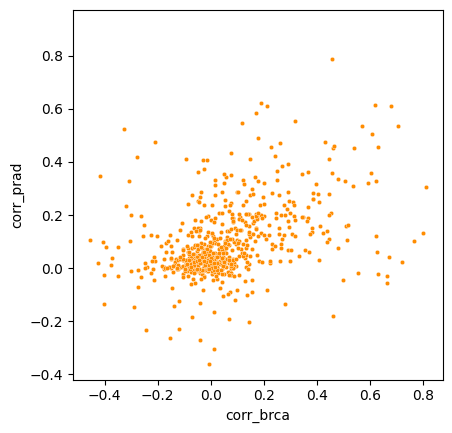

In [125]:
sns.scatterplot(data=dtype_to_df['xenium'], x='corr_brca', y='corr_prad', c='darkorange', s=10)
plt.axis('square')

In [126]:
f = dtype_to_df['xenium'].copy()
f['score'] = f['corr_brca'] * f['corr_prad']


In [127]:
x = f[f['corr_brca'] > .3]
x = x[x['corr_prad'] > .3]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_positive'] += genes
for g in genes: print(g)

DST
TP63
COL17A1
KRT5
GATA3
KRT17
LTBP2
SCNN1A
MET
LAMC2
VWA5A
TNC
PDPN
PLAT
CAV1
PTPRZ1
KRT14
PCNX1
SAA1
PROM1
KITLG
GPX2
CAVIN1
CLCA2


In [128]:
x = f[f['corr_brca'] > .3]
x = x[x['corr_prad'] < .1]
genes = x.sort_values('corr_prad', ascending=True).index.to_list()
gene_lists['brca_positive'] += genes
for g in genes: print(g)

TMPRSS2
MYH11
SLC39A6
SREBF1
CNN1
PTN
MYLK
PPP1R1B
ACTA2
MMRN2
MAMDC2
ERG
TFPI
MBP
PDGFRA
VIM


In [129]:
x = f[f['corr_brca'] < .1]
x = x[x['corr_prad'] > .3]
genes = x.sort_values('corr_brca', ascending=True).index.to_list()
gene_lists['prad_positive'] += genes
for g in genes: print(g)

GPRC5A
KRT19
LYPD3
IRAK3
KRT7
SOX2
MDM2
CD74
KLK11
AMY2B
AQP3
CLIC6
EDN1
SYPL1
CFTR
S100P
CCL2


In [130]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_negative'] += genes
for g in genes: print(g)

FBP1
SCD
STEAP1
AMACR
GLYATL1
EPHA6
ONECUT2


In [131]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] > .1]
genes = x.sort_values('corr_prad', ascending=False).index.to_list()
gene_lists['brca_negative'] += genes
for g in genes: print(g)

KRT19
KRT7
IRAK3
GPRC5A
LYPD3
PCNA
KRT8
S100A4
CCND1
TLE4
KLRC1
ENPP3
KRT18
AZGP1
VEGFA
CTSK
ATP6V1C1
VCAN
S100A1


In [132]:
x = f[f['corr_brca'] > .1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('corr_brca', ascending=False).index.to_list()
gene_lists['prad_negative'] += genes
for g in genes: print(g)

TMPRSS2
ANPEP
ALDH1A3
GPR160


(-0.3605374590230666,
 0.8735457386247649,
 -0.355729380432333,
 0.8783538172154985)

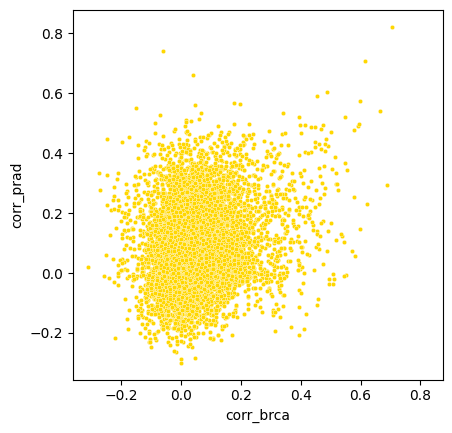

In [133]:
sns.scatterplot(data=dtype_to_df['vishd'], x='corr_brca', y='corr_prad', c='gold', s=10)
plt.axis('square')

In [134]:
f = dtype_to_df['vishd'].copy()
f['score'] = f['corr_brca'] * f['corr_prad']

In [135]:
x = f[f['corr_brca'] > .4]
x = x[x['corr_prad'] > .4]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_positive'] += genes
for g in genes: print(g)

KRT5
TRIM29
KRT17
LAMB3
ITGB4
GSTP1
DST
DSC3
WFDC2
TP63
ITGA2
ANXA1
TNS4
OBSCN
ITGB8
SLPI
A2M
F3
S100A6
COL7A1
EFNA5
ITGB6
TINAGL1
ITGA3
PERP
DEFB1
SCPEP1
PIK3R1


In [136]:
x = f[f['corr_brca'] > .4]
x = x[x['corr_prad'] < .1]
genes = x.sort_values('corr_prad', ascending=True).index.to_list()
gene_lists['brca_positive'] += genes
for g in genes: print(g)

ANPEP
IRX2
IRX4
FAM20C
NFIX
CCDC9B
MIA
ELF5
PHGDH
KLK5
KRT6B
IRX1
SOX10
KLK7
GUCY1A1
SBSPON
C5orf46
CHI3L1
KCNMB1
PPP1R14C
RASSF10
NFIB
SYNM
CNN1
ECRG4
LAD1
ACTG2
SLC34A2


In [137]:
x = f[f['corr_brca'] < .1]
x = x[x['corr_prad'] > .4]
genes = x.sort_values('corr_brca', ascending=True).index.to_list()
gene_lists['prad_positive'] += genes
for g in genes: print(g)

SERPINF1
C3
RHOB
GJA1
DDIT4
TSC22D3
STOM
CHPT1
XG
APOL1
GLUL
RUNX1
THSD4
BHLHE40
WIPF1
KRT19
KRT15
GPX3
SORL1
CYP4X1
IRX3
SLC2A5
GBP4
ID1
LIPC
SELENOM
EPAS1
APOBR
HOXD10
AVPI1
C1R
SLFN12
NCKAP1L
IFITM3
WNT3A
GRASP
EPB41L2
XAF1
ZFP36L1
TRIB2
CPA6
TMSB4X
UCP2
ANXA2
APOL4
CSF2RA
HOXD11
APOL5
MUC4
CYP3A5
SIRPB2
LGALS3
CYP4B1
RASAL3
SPTLC3
MFSD4A
NTN4
ARRDC2
DBNDD2
RASSF4
CLDN1
CD74
PDK4
HEXA
ZEB2
ARHGEF19
DUOX2
INKA1
ENPP2
TMEM173
KLK11
CD4
S1PR5


In [138]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_negative'] += genes
for g in genes: print(g)

NPNT
FASN
CPNE7
CNTNAP2
MLPH
HID1
TPD52
INPP4B
EEF1A2
ABAT
TP53INP1
GREB1
NPR3
KLK4
ARHGEF38
PYCR1
FOXA1
CRAT
SPDEF
MAPK8IP2
FAM110B
MCCC2
NTNG2
ALCAM
AR
GSE1
STEAP4
PRRT2
PRLR
TRPM4
ABLIM3
ERGIC1


In [139]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] > .2]
genes = x.sort_values('corr_prad', ascending=False).index.to_list()
gene_lists['brca_negative'] += genes
for g in genes: print(g)

GJA1
RHOB
SERPINF1
CHPT1
C3
XG
DDIT4
STOM
TSC22D3
CYBRD1
KRT23
TCIM
TIMP2
PREX1
TIMP3
DCN
LPAR5
VWA2
MMP2
PRSS23
FN1
PRRX1
CRISPLD2
LRP1
CCDC3
MAP3K1
SPTSSB
DUSP4
HTRA1
ARHGAP40
TMEM119
SFRP2
LUM
C1S
KLF2
EFHD1
LTBP1
VCAM1
TGFB3
SPARC
MS4A7
PGR
GSTM3
ASPH
SERPINA11
AEBP1
FBLN1
CCN4
COL14A1
FGD3
IGFBP4
COL6A3
SLC38A1
NBL1
RAB31
IGF1
GPRC5A
EMP2
SPON1
CTSK
RASGRF2
CCDC80
ELN
MAN1A1
ETNK2
COL1A2
COL3A1


In [140]:
x = f[f['corr_brca'] > .2]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('corr_brca', ascending=False).index.to_list()
gene_lists['prad_negative'] += genes
for g in genes: print(g)

IRX4
IRX2
ANPEP
PPP1R1B
LGR4
DLGAP1
IRS2
LARGE2
C1orf116
AMOTL1
TMPRSS2
TUSC3
SPTBN2
PLEKHB1
SLC25A37
LRATD1
BICD1
MESP1
ZNF462
RASSF3
MSI1


In [141]:
for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            gene_lists[key] += f.index.to_list()

for k, v in gene_lists.items():
    print(k, len(set(v)))

for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, f in d1.items():
        key = f'{disease}_{direction}'
        gene_lists[key] += f.index.to_list()

for k, v in gene_lists.items():
    print(k, len(set(v)))

diseases = ['brca', 'prad']
dtypes = ['xenium', 'cosmx', 'vishd']
idents = ['region', 'tme']
exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
tups = [(ident, dtype) for ident in idents for dtype in dtypes]
for i, disease in enumerate(diseases):
    for j, dtype in enumerate(dtypes):
        for k, ident in enumerate(idents):
            df = corr_dfs[f'{disease}_{dtype}_{ident}']
            idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
            source = df.loc[idxs]
            source = source[~pd.isnull(source['correlation'])]
            if source.shape[0]:
                if n * 2 < source.shape[0]:
                    source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                source = source.sort_values('correlation', ascending=False)
                source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]

                for feat, corr in zip(source.index.to_list(), source['correlation']):
                    if corr > 0:
                        gene_lists[f'{disease}_positive'].append(feat)
                    else:
                        gene_lists[f'{disease}_negative'].append(feat)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 100
brca_negative 120
prad_positive 142
prad_negative 76
combined_positive 48
combined_negative 39
brca_positive 102
brca_negative 122
prad_positive 151
prad_negative 77
combined_positive 48
combined_negative 39
brca_positive 131
brca_negative 147
prad_positive 167
prad_negative 88
combined_positive 48
combined_negative 39


In [142]:

a = set(gene_lists['brca_positive'])
b = set(gene_lists['prad_positive'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_positive'])
d = set.union(common, c)

gene_lists['brca_positive'] = sorted(a)
gene_lists['prad_positive'] = sorted(b)
gene_lists['combined_positive'] = sorted(d)

a = set(gene_lists['brca_negative'])
b = set(gene_lists['prad_negative'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_negative'])
d = set.union(common, c)

gene_lists['brca_negative'] = sorted(a)
gene_lists['prad_negative'] = sorted(b)
gene_lists['combined_negative'] = sorted(d)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 100
brca_negative 145
prad_positive 136
prad_negative 86
combined_positive 61
combined_negative 39


In [143]:
for k, v in gene_lists.items():
    print(k)
    for x in v:
        print(x)

    print()
    print()
    print()

brca_positive
ACTA2
ACTG2
ANPEP
ANXA1
APP
ARFGEF3
BBOX1
C5orf46
CALD1
CALML3
CCDC9B
CDH1
CDH3
CHI3L1
CNN1
CRYAB
DSG3
ECRG4
ELF5
EPHB4
ERG
FAM20C
FBLN1
GAS6
GUCY1A1
IFFO2
IFI44L
IRX1
IRX2
IRX4
ITGA2
ITGA3
JUN
KCNMB1
KITLG
KLK5
KLK7
KRT6A/B/C
KRT6B
LAD1
LAMC2
LEPR
MAMDC2
MBP
MGP
MIA
MMP7
MMRN2
MUC1
MYH11
MYL9
MYLK
NFIB
NFIX
NGFR
NTRK2
PDGFRA
PDLIM4
PHGDH
PLAT
PPP1R14C
PPP1R1B
PTCH1
PTN
RASSF10
S100A2
SAA1/2
SBSPON
SCNN1A
SFN
SLC34A2
SLC39A6
SNCG
SOX10
SREBF1
STC2
SYNM
SYT8
TACSTD2
TAGLN
TBX18
TCIM
TFPI
THBS1
TINAGL1
TLE4
TM4SF18
TMPRSS2
TPM2
WFDC2
cd11b
ckit
cox6c
ctla4
her2
ki67
mgp
plat/tpa
slc39a6
tff1



brca_negative
ADAM8
AEBP1
AREG
ARHGAP40
ASPH
ASPN
ASXL1_p.P808Lfs__10_WT
ATP6V1C1
AZGP1
BAMBI
BLANK_0416
BRCA2_p.A938fs_ALT:-
C15orf48
C1S
C3
CCDC3
CCDC78
CCDC80
CCN4
CCND1
CDKN2A
CDKN2A_p14arf
CDKN2A_p16
CENPF
CHPT1
CILP
CILP2
COL10A1
COL11A1
COL12A1
COL14A1
COL1A1
COL1A2
COL3A1
COL5A2
COL6A3
COL8A1
COMP
COX6C
CRISPLD2
CTNNB1_p.S45Y_ALT:A
CTSK
CXCL12
CXCL9
CYBRD1
DCN
DDIT4
DPT
DUSP4

In [1006]:
for k, vs in gene_lists.items():
    for v in vs:
        print(f'{k}\t{v}')

brca_positive	ACTA2
brca_positive	ACTG2
brca_positive	ANPEP
brca_positive	ANXA1
brca_positive	APP
brca_positive	ARFGEF3
brca_positive	BBOX1
brca_positive	C5orf46
brca_positive	CALD1
brca_positive	CALML3
brca_positive	CCDC9B
brca_positive	CDH1
brca_positive	CDH3
brca_positive	CHI3L1
brca_positive	CNN1
brca_positive	CRYAB
brca_positive	DSG3
brca_positive	ECRG4
brca_positive	ELF5
brca_positive	ERG
brca_positive	FAM20C
brca_positive	FBLN1
brca_positive	GAS6
brca_positive	GUCY1A1
brca_positive	IFFO2
brca_positive	IFI44L
brca_positive	IRX1
brca_positive	IRX2
brca_positive	IRX4
brca_positive	ITGA2
brca_positive	ITGA3
brca_positive	JUN
brca_positive	KCNMB1
brca_positive	KITLG
brca_positive	KLK5
brca_positive	KLK7
brca_positive	KRT6A/B/C
brca_positive	KRT6B
brca_positive	LAD1
brca_positive	LAMC2
brca_positive	LEPR
brca_positive	MAMDC2
brca_positive	MBP
brca_positive	MGP
brca_positive	MIA
brca_positive	MMP7
brca_positive	MMRN2
brca_positive	MUC1
brca_positive	MYH11
brca_positive	MYL9
brca_positi